## Pip Installs

In [ ]:
%%capture
!pip install beautifulsoup4 yfinance torch alpaca-trade-api alpaca-py

In [ ]:
%%capture
!pip install "stable-baselines3[extra]" sb3-contrib gym pandas numpy matplotlib "shimmy>=2.0"

In [ ]:
%%capture
!pip install python-dotenv

## Alpaca

In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import alpaca_trade_api as tradeapi
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

In [ ]:
%%writefile .env
APCA_API_KEY_ID=HIDDEN
APCA_API_SECRET_KEY=HIDDEN

Writing .env


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

API_KEY = os.getenv("APCA_API_KEY_ID")
API_SECRET = os.getenv("APCA_API_SECRET_KEY")

In [ ]:
from alpaca.trading.client import TradingClient

trading_client = TradingClient(API_KEY, API_SECRET, paper=True)

In [ ]:
# Alpaca API credentials
api_key = "PK2DSD4BN8QNOYWSC5I1"
secret_key = "eGSHvlwHLcuf24k0cTKXDPYFMjs3n1per4SsAys8"

In [ ]:
# Create market buy order request
order_request = MarketOrderRequest(
    symbol="AAPL",                # Ticker symbol
    qty=1,                        # Number of shares
    side=OrderSide.BUY,          # Buy or Sell
    time_in_force=TimeInForce.DAY  # Order valid for the trading day
)

# Submit the order
order = trading_client.submit_order(order_request)
print("Order submitted:", order.id)

Order submitted: 1acc9f87-e4f9-4296-a2f2-2a13453cbed0


In [ ]:
account = trading_client.get_account()

# Access fields
print("Cash:", account.cash)
print("Buying power:", account.buying_power)
print("Portfolio value:", account.portfolio_value)

Cash: 100000
Buying power: 199796.67
Portfolio value: 100000


In [ ]:
positions = trading_client.get_all_positions()

for position in positions:
    print(f"{position.symbol}: {position.qty} shares at ${position.avg_entry_price}")

## SEED (Set Before Trading Env)
Set the initial seed

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import numpy as np
import random
import torch

# Fix all seeds
SEED = 83819
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

## Main Logic (Initialize)

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import requests
from bs4 import BeautifulSoup
import re
import io
from PIL import Image
import math
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEBUG = True
def debug_print(msg):
    if DEBUG:
        print(msg)

In [ ]:
# FOMC Dates Scraper
def get_fomc_dates(start_date, end_date):
    url = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            debug_print(f"Error: Received status code {response.status_code}")
            return []
        soup = BeautifulSoup(response.text, "html.parser")
        date_objs = []
        for text in soup.stripped_strings:
            matches = re.findall(r'([A-Za-z]+ \d{1,2}, \d{4})', text)
            for date_str in matches:
                try:
                    dt = datetime.strptime(date_str, "%B %d, %Y")
                    if dt not in date_objs:
                        date_objs.append(dt)
                except Exception:
                    continue
        date_objs = sorted(date_objs)
        start_dt = pd.to_datetime(start_date)
        end_dt = pd.to_datetime(end_date)
        filtered_dates = [dt for dt in date_objs if start_dt <= dt <= end_dt]
        return filtered_dates
    except Exception as e:
        debug_print(f"Error scraping FOMC dates: {e}")
        return []

In [ ]:
# Indicator Functions
def exp_average(series, period):
    return series.ewm(span=period, adjust=False).mean()

def wilder_average(series, length):
    return series.ewm(alpha=1/length, adjust=False).mean()

def weighted_moving_average(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def t3(source, length=21, vf=0.7):
    ema1 = exp_average(source, length)
    ema2 = exp_average(ema1, length)
    gd1 = ema1*(1+vf) - ema2*vf
    ema11 = exp_average(gd1, length)
    ema22 = exp_average(ema11, length)
    gd2 = ema11*(1+vf) - ema22*vf
    ema111 = exp_average(gd2, length)
    ema222 = exp_average(ema111, length)
    gd3 = ema111*(1+vf) - ema222*vf
    return gd3

def vwma(series, window, volume):
    return (series*volume).rolling(window=window, min_periods=window).sum()/volume.rolling(window=window, min_periods=window).sum()

def rsi_function(close, sensitivity, rsiPeriod, rsiBase):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsiPeriod, min_periods=rsiPeriod).mean()
    avg_loss = loss.rolling(window=rsiPeriod, min_periods=rsiPeriod).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100/(1+rs))
    rsi = rsi.fillna(50)
    rsi_adj = sensitivity*(rsi-rsiBase)
    return rsi_adj.clip(lower=0, upper=20)

def download_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0].lower() for col in df.columns]
    else:
        df.columns = [str(col).lower() for col in df.columns]
    return df

def compute_bressert(df, n_period=8, r_period=13):
    df['Ln'] = df['low'].rolling(window=n_period, min_periods=1).min()
    df['Hn'] = df['high'].rolling(window=n_period, min_periods=1).max()
    df['Y'] = ((df['close']-df['Ln'])/(df['Hn']-df['Ln']))*100
    df['X'] = exp_average(df['Y'], r_period)
    df['Lxn'] = df['X'].rolling(window=n_period, min_periods=1).min()
    df['Hxn'] = df['X'].rolling(window=n_period, min_periods=1).max()
    df['DSS'] = ((df['X']-df['Lxn'])/(df['Hxn']-df['Lxn']))*100
    df['DSSb'] = exp_average(df['DSS'], r_period)
    df['DSSsignal'] = df['DSSb'].shift(1)
    return df

def compute_zscore(df, length_m=14):
    momentum = df['close'] - df['close'].shift(length_m)
    avgMomentum = momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdDevMomentum = momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    zScore = (momentum - avgMomentum)/stdDevMomentum
    return zScore

def compute_zero_lag_macd(source, fastLength=12, slowLength=26, signalLength=9, MacdEmaLength=9, useEma=True, useOldAlgo=False):
    if useEma:
        ma1 = source.ewm(span=fastLength, adjust=False).mean()
        ma2 = ma1.ewm(span=fastLength, adjust=False).mean()
    else:
        ma1 = source.rolling(window=fastLength, min_periods=fastLength).mean()
        ma2 = ma1.rolling(window=fastLength, min_periods=fastLength).mean()
    zerolagEMA = (2*ma1) - ma2
    if useEma:
        mas1 = source.ewm(span=slowLength, adjust=False).mean()
        mas2 = mas1.ewm(span=slowLength, adjust=False).mean()
    else:
        mas1 = source.rolling(window=slowLength, min_periods=slowLength).mean()
        mas2 = mas1.rolling(window=slowLength, min_periods=slowLength).mean()
    zerolagslowMA = (2*mas1) - mas2
    ZeroLagMACD = zerolagEMA - zerolagslowMA
    emasig1 = ZeroLagMACD.ewm(span=signalLength, adjust=False).mean()
    emasig2 = emasig1.ewm(span=signalLength, adjust=False).mean()
    if useOldAlgo:
        signal = ZeroLagMACD.rolling(window=signalLength, min_periods=signalLength).mean()
    else:
        signal = (2*emasig1) - emasig2
    hist = ZeroLagMACD - signal
    upHist = hist.copy()
    upHist[hist <= 0] = 0
    downHist = hist.copy()
    downHist[hist > 0] = 0
    EMALine = ZeroLagMACD.ewm(span=MacdEmaLength, adjust=False).mean()
    dotUP = ZeroLagMACD.copy()
    dotUP[(ZeroLagMACD.shift(1) >= signal.shift(1)) | (ZeroLagMACD < signal)] = np.nan
    dotDN = ZeroLagMACD.copy()
    dotDN[(ZeroLagMACD.shift(1) <= signal.shift(1)) | (ZeroLagMACD > signal)] = np.nan
    return {
        "ZeroLagMACD": ZeroLagMACD,
        "signal": signal,
        "hist": hist,
        "upHist": upHist,
        "downHist": downHist,
        "EMALine": EMALine,
        "dotUP": dotUP,
        "dotDN": dotDN
    }

def compute_basic_macd(source, fast=12, slow=26, signal=9):
    ema_fast = source.ewm(span=fast, adjust=False).mean()
    ema_slow = source.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist_line = macd_line - signal_line
    return {
        "basicMACD": macd_line,
        "signal": signal_line,
        "hist": hist_line
    }

In [ ]:
# Historical Signals Extraction
def extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
                    upSig_MCDX, dnSig_MCDX, length_m=14):
    """
    Combines ZLMA, RSI, MCDX, DSS signals in a single table.
    """
    signals = []
    zScore = compute_zscore(df, length_m)

    # ZLMA
    for dt in df.index[signalUp_ZLMA.fillna(False)]:
        signals.append({
            "Date": dt.strftime("%Y-%m-%d"),
            "Signal": "ZLMA Buy",
            "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    for dt in df.index[signalDn_ZLMA.fillna(False)]:
        signals.append({
            "Date": dt.strftime("%Y-%m-%d"),
            "Signal": "ZLMA Sell",
            "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    # RSI
    if isinstance(bullPt, pd.Series):
        for dt in bullPt.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "RSI Buy",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    if isinstance(bearPt, pd.Series):
        for dt in bearPt.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "RSI Sell",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    # MCDX
    if isinstance(upSig_MCDX, pd.Series):
        for dt in upSig_MCDX.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "MCDX Buy",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    if isinstance(dnSig_MCDX, pd.Series):
        for dt in dnSig_MCDX.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "MCDX Sell",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    # DSS
    for i in range(1, len(df)):
        if (pd.notna(df['DSSb'].iloc[i]) and pd.notna(df['DSSsignal'].iloc[i]) and
            pd.notna(df['DSSb'].iloc[i-1]) and pd.notna(df['DSSsignal'].iloc[i-1])):
            if df['DSSb'].iloc[i] > df['DSSsignal'].iloc[i] and df['DSSb'].iloc[i-1] <= df['DSSsignal'].iloc[i-1]:
                dt = df.index[i]
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "DSS Buy",
                    "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
                })
            elif df['DSSb'].iloc[i] < df['DSSsignal'].iloc[i] and df['DSSb'].iloc[i-1] >= df['DSSsignal'].iloc[i-1]:
                dt = df.index[i]
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "DSS Sell",
                    "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
                })

    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_momentum_signals(df, length_m=14):
    """
    Momentum-based signals. Checks momentum grade changes, direction changes, and state changes.
    """
    momentum = df['close'] - df['close'].shift(length_m)
    avgMomentum = momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdDevMomentum = momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    zScore = (momentum - avgMomentum) / stdDevMomentum

    def grade(x):
        if x >= 2:
            return "A"
        elif x >= 1:
            return "B"
        elif x >= 0:
            return "C"
        elif x >= -1:
            return "D"
        elif x >= -2:
            return "E"
        else:
            return "F"

    momentum_grade = zScore.apply(grade)
    momentum_direction = momentum.apply(lambda x: "Increasing" if x>0 else "Decreasing")

    momentum_state = []
    for i in range(len(momentum)):
        if i == 0:
            momentum_state.append("N/A")
        else:
            if abs(momentum.iloc[i]) < abs(momentum.iloc[i-1]) * 0.0001:
                momentum_state.append("Consolidating")
            elif momentum.iloc[i] * momentum.iloc[i-1] < 0:
                if momentum.iloc[i] > 0:
                    momentum_state.append("Turning Up")
                else:
                    momentum_state.append("Turning Down")
            elif (momentum.iloc[i] > 0 and (momentum.iloc[i] - momentum.iloc[i-1]) < 0) or (momentum.iloc[i] < 0 and (momentum.iloc[i] - momentum.iloc[i-1]) > 0):
                momentum_state.append("Stalling")
            elif momentum.iloc[i] > 0:
                momentum_state.append("Positive Trending")
            else:
                momentum_state.append("Negative Trending")
    momentum_state = pd.Series(momentum_state, index=df.index)

    signals = []
    for i in range(1, len(df)):
        # Grade
        if momentum_grade.iloc[i] != momentum_grade.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum Grade Changed to {momentum_grade.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
        # Direction
        if momentum_direction.iloc[i] != momentum_direction.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum Direction Changed to {momentum_direction.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
        # State
        if momentum_state.iloc[i] != momentum_state.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum State Changed to {momentum_state.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_zero_macd_signals(df, zero_macd_dict, length_m=14):
    macd_line = zero_macd_dict["ZeroLagMACD"]
    macd_mean = macd_line.rolling(window=length_m, min_periods=length_m).mean()
    macd_std = macd_line.rolling(window=length_m, min_periods=length_m).std().replace(0, np.nan)
    macd_zscore = (macd_line - macd_mean)/macd_std

    signals = []
    for i in range(1, len(df)):
        if (pd.notna(zero_macd_dict["ZeroLagMACD"].iloc[i]) and
            pd.notna(zero_macd_dict["signal"].iloc[i]) and
            pd.notna(zero_macd_dict["ZeroLagMACD"].iloc[i-1]) and
            pd.notna(zero_macd_dict["signal"].iloc[i-1])):
            dt = df.index[i]
            if zero_macd_dict["ZeroLagMACD"].iloc[i] > zero_macd_dict["signal"].iloc[i] and zero_macd_dict["ZeroLagMACD"].iloc[i-1] <= zero_macd_dict["signal"].iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "ZeroLag MACD Buy",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
            elif zero_macd_dict["ZeroLagMACD"].iloc[i] < zero_macd_dict["signal"].iloc[i] and zero_macd_dict["ZeroLagMACD"].iloc[i-1] >= zero_macd_dict["signal"].iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "ZeroLag MACD Sell",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_basic_macd_signals(df, basic_macd_dict, length_m=14):
    macd_line   = basic_macd_dict["basicMACD"]
    signal_line = basic_macd_dict["signal"]
    macd_mean   = macd_line.rolling(window=length_m, min_periods=length_m).mean()
    macd_std    = macd_line.rolling(window=length_m, min_periods=length_m).std().replace(0, np.nan)
    macd_zscore = (macd_line - macd_mean)/macd_std

    signals=[]
    for i in range(1, len(df)):
        if (pd.notna(macd_line.iloc[i]) and pd.notna(signal_line.iloc[i]) and
            pd.notna(macd_line.iloc[i-1]) and pd.notna(signal_line.iloc[i-1])):
            dt= df.index[i]
            # cross up
            if macd_line.iloc[i]> signal_line.iloc[i] and macd_line.iloc[i-1]<= signal_line.iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "Basic MACD Buy",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
            # cross down
            elif macd_line.iloc[i]< signal_line.iloc[i] and macd_line.iloc[i-1]>= signal_line.iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "Basic MACD Sell",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
    signals_df= pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"]= pd.to_datetime(signals_df["Date"])
        signals_df= signals_df.sort_values("Date", ascending=False)
    return signals_df

In [ ]:
# RSI and MCDX signals
def calc_rsi_entire_series(df, bullPt, bearPt):
    rsi_series = []
    last_signal = "Sell"
    for i in range(len(df)):
        if isinstance(bullPt, pd.Series) and pd.notna(bullPt.iloc[i]):
            last_signal = "Buy"
        elif isinstance(bearPt, pd.Series) and pd.notna(bearPt.iloc[i]):
            last_signal = "Sell"
        rsi_series.append(last_signal)
    return pd.Series(rsi_series, index=df.index)

def calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX):
    mcdx_series = []
    last_signal = "Sell"
    for i in range(len(df)):
        if pd.notna(upSig_MCDX.iloc[i]):
            last_signal = "Buy"
        elif pd.notna(dnSig_MCDX.iloc[i]):
            last_signal = "Sell"
        mcdx_series.append(last_signal)
    return pd.Series(mcdx_series, index=df.index)

In [ ]:
# Weighted scoreboard
def scoreboard_for_day(
    df, i,
    rsi_series, mcdx_series,
    zero_macd_dict, basic_macd_dict,
    length_m=14,
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    # ZLMA => Buy if zlma>ema_value
    zlma_status= "Buy" if df['zlma'].iloc[i]> df['ema_value'].iloc[i] else "Sell"
    # RSI => from daily rsi_series
    rsi_status= rsi_series.iloc[i]
    # MCDX => from daily mcdx_series
    mcdx_status= mcdx_series.iloc[i]
    # DSS => Buy if DSSb>DSSsignal
    dss_status= "Buy" if df['DSSb'].iloc[i]> df['DSSsignal'].iloc[i] else "Sell"

    # Z-Score => positive => Buy
    zVal= compute_zscore(df, length_m).iloc[i]
    z_status= "Buy" if zVal>=0 else "Sell"

    # Momentum Grade
    momentum= df['close']- df['close'].shift(length_m)
    avgM= momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdM= momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    z_m= (momentum-avgM)/stdM
    mg_z= z_m.iloc[i] if not pd.isna(z_m.iloc[i]) else 0
    if mg_z>=2:
        mg_grade="A"
    elif mg_z>=1:
        mg_grade="B"
    elif mg_z>=0:
        mg_grade="C"
    elif mg_z>=-1:
        mg_grade="D"
    elif mg_z>=-2:
        mg_grade="E"
    else:
        mg_grade="F"
    mg_status= "Buy" if mg_grade in ["A","B","C"] else "Sell"

    # Momentum Direction
    if i==0:
        md_status="Sell"
    else:
        md_status= "Buy" if momentum.iloc[i]> momentum.iloc[i-1] else "Sell"

    # Momentum State
    if i==0:
        ms_val=0
    else:
        val_now= momentum.iloc[i]
        val_prev= momentum.iloc[i-1]
        change= val_now- val_prev
        ms_val=0
        if val_now>0 and val_prev<0:
            ms_val=1
        elif val_now<0 and val_prev>0:
            ms_val=-1
        elif abs(val_now)< abs(avgM.iloc[i])*0.1:
            ms_val=0
        elif (val_now>0 and change<0) or (val_now<0 and change>0):
            ms_val=0
        elif val_now>0:
            ms_val=1
        else:
            ms_val=-1
    if ms_val>0:
        ms_status="Buy"
    elif ms_val<0:
        ms_status="Sell"
    else:
        ms_status="Neutral"

    zero_macd_status="Sell"
    if zero_macd_dict is not None:
        if zero_macd_dict["ZeroLagMACD"].iloc[i]> zero_macd_dict["signal"].iloc[i]:
            zero_macd_status="Buy"
        else:
            zero_macd_status="Sell"

    basic_macd_status="Sell"
    if basic_macd_dict is not None:
        if basic_macd_dict["basicMACD"].iloc[i]> basic_macd_dict["signal"].iloc[i]:
            basic_macd_status="Buy"
        else:
            basic_macd_status="Sell"

    scoreboard=[]
    scoreboard.append(weight_zlma if zlma_status=="Buy" else -weight_zlma)
    scoreboard.append(weight_rsi  if rsi_status=="Buy" else -weight_rsi)
    scoreboard.append(weight_mcdx if mcdx_status=="Buy" else -weight_mcdx)
    scoreboard.append(weight_dss  if dss_status=="Buy" else -weight_dss)
    scoreboard.append(weight_zscore if zVal>=0 else -weight_zscore)
    scoreboard.append(weight_mg if mg_status=="Buy" else -weight_mg)
    scoreboard.append(weight_md if md_status=="Buy" else -weight_md)

    ms_val_weighted=0
    if ms_status=="Buy":
        ms_val_weighted= weight_ms
    elif ms_status=="Sell":
        ms_val_weighted= -weight_ms
    scoreboard.append(ms_val_weighted)

    scoreboard.append(weight_zeromacd if zero_macd_status=="Buy" else -weight_zeromacd)
    scoreboard.append(weight_basicmacd if basic_macd_status=="Buy" else -weight_basicmacd)

    total_signals= sum(1 for x in scoreboard if x!=0)
    bullish_count= sum(1 for x in scoreboard if x>0)

    if total_signals==0:
        return "Neutral"
    else:
        if bullish_count>= (total_signals/2.0):
            return "Buy"
        else:
            return "Sell"

In [ ]:
# Historical Trade Table
def simulate_trades_overall_signal(
    df, rsi_series, mcdx_series,
    zero_macd_dict, basic_macd_dict,
    length_m=14,
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    position = 0
    entry_price = 0.0
    trade_log = []
    cumulative_pnl_sum = 0.0
    prev_signal = "Neutral"

    for i in range(len(df)):
        day_signal = scoreboard_for_day(
            df, i, rsi_series, mcdx_series,
            zero_macd_dict, basic_macd_dict,
            length_m,
            weight_zlma, weight_rsi, weight_mcdx, weight_dss,
            weight_zscore, weight_mg, weight_md, weight_ms,
            weight_zeromacd, weight_basicmacd
        )
        price_i = df['close'].iloc[i]
        date_i = df.index[i]

        # Flip from Sell->Buy => close short
        if prev_signal in ["Sell", "Neutral"] and day_signal == "Buy":
            if position == -1:
                exit_price = price_i
                pnl_pct = ((entry_price / exit_price) - 1)*100
                cumulative_pnl_sum += pnl_pct
                trade_log.append({
                    "EntryDate": entry_dt_str,
                    "ExitDate": date_i.strftime("%Y-%m-%d"),
                    "Position": "Short",
                    # Round to 4 decimal places:
                    "EntryPrice": round(entry_price, 4),
                    "ExitPrice": round(exit_price, 4),
                    "PnL%": round(pnl_pct, 2),
                    "CumulativePnL%": round(cumulative_pnl_sum, 2)
                })
                position = 0
            position = 1
            entry_price = price_i
            entry_dt_str = date_i.strftime("%Y-%m-%d")

        # Flip from Buy->Sell => close long
        elif prev_signal in ["Buy", "Neutral"] and day_signal == "Sell":
            if position == 1:
                exit_price = price_i
                pnl_pct = ((exit_price / entry_price) - 1)*100
                cumulative_pnl_sum += pnl_pct
                trade_log.append({
                    "EntryDate": entry_dt_str,
                    "ExitDate": date_i.strftime("%Y-%m-%d"),
                    "Position": "Long",
                    "EntryPrice": round(entry_price, 4),
                    "ExitPrice": round(exit_price, 4),
                    "PnL%": round(pnl_pct, 2),
                    "CumulativePnL%": round(cumulative_pnl_sum, 2)
                })
                position = 0
            position = -1
            entry_price = price_i
            entry_dt_str = date_i.strftime("%Y-%m-%d")

        prev_signal = day_signal

    # Close any open position at the end
    if position != 0:
        final_price = df['close'].iloc[-1]
        final_date = df.index[-1]
        if position == 1:
            exit_price = final_price
            pnl_pct = ((exit_price / entry_price) - 1)*100
            cumulative_pnl_sum += pnl_pct
            trade_log.append({
                "EntryDate": entry_dt_str,
                "ExitDate": final_date.strftime("%Y-%m-%d"),
                "Position": "Long",
                "EntryPrice": round(entry_price, 4),
                "ExitPrice": round(exit_price, 4),
                "PnL%": round(pnl_pct, 2),
                "CumulativePnL%": round(cumulative_pnl_sum, 2)
            })
        else:
            exit_price = final_price
            pnl_pct = ((entry_price / exit_price) - 1)*100
            cumulative_pnl_sum += pnl_pct
            trade_log.append({
                "EntryDate": entry_dt_str,
                "ExitDate": final_date.strftime("%Y-%m-%d"),
                "Position": "Short",
                "EntryPrice": round(entry_price, 4),
                "ExitPrice": round(exit_price, 4),
                "PnL%": round(pnl_pct, 2),
                "CumulativePnL%": round(cumulative_pnl_sum, 2)
            })

    trade_df = pd.DataFrame(trade_log)
    trade_df["ExitDate_dt"] = pd.to_datetime(trade_df["ExitDate"])
    trade_df = trade_df.sort_values("ExitDate_dt", ascending=False).reset_index(drop=True)
    trade_df.drop(columns=["ExitDate_dt"], inplace=True)
    return trade_df

In [ ]:
# Scoreboard with ZeroLag + Basic MACD
def extract_current_status(
    df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
    upSig_MCDX, dnSig_MCDX,
    length_m=14,
    zero_macd_dict=None, basic_macd_dict=None,

    # Weighted scoreboard
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    i= len(df)-1
    zlma_status= "Buy" if df['zlma'].iloc[i]> df['ema_value'].iloc[i] else "Sell"

    # RSI day-by-day
    daily_rsi_series  = calc_rsi_entire_series(df, bullPt, bearPt)
    rsi_status        = daily_rsi_series.iloc[i]
    # MCDX day-by-day
    daily_mcdx_series = calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
    mcdx_status       = daily_mcdx_series.iloc[i]
    # DSS => buy if DSSb>DSSsignal
    dss_status= "Buy" if df['DSSb'].iloc[i]> df['DSSsignal'].iloc[i] else "Sell"

    # Z-Score
    zVal= compute_zscore(df, length_m).iloc[i]
    z_status= "Buy" if zVal>=0 else "Sell"

    # Momentum
    momentum= df['close']- df['close'].shift(length_m)
    avgM= momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdM= momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    z_m= (momentum-avgM)/ stdM
    mg_z= z_m.iloc[i] if not pd.isna(z_m.iloc[i]) else 0
    if mg_z>=2:
        mg_letter="A"
    elif mg_z>=1:
        mg_letter="B"
    elif mg_z>=0:
        mg_letter="C"
    elif mg_z>=-1:
        mg_letter="D"
    elif mg_z>=-2:
        mg_letter="E"
    else:
        mg_letter="F"
    mg_status= "Buy" if mg_letter in ["A","B","C"] else "Sell"

    # momentum direction
    if i==0:
        md_status="Sell"
    else:
        md_status= "Buy" if momentum.iloc[i]> momentum.iloc[i-1] else "Sell"

    # momentum state
    if i==0:
        ms_val=0
    else:
        val_now= momentum.iloc[i]
        val_prev= momentum.iloc[i-1]
        change= val_now- val_prev
        ms_val=0
        if val_now>0 and val_prev<0:
            ms_val=1
        elif val_now<0 and val_prev>0:
            ms_val=-1
        elif abs(val_now)< abs(avgM.iloc[i])*0.1:
            ms_val=0
        elif (val_now>0 and change<0) or (val_now<0 and change>0):
            ms_val=0
        elif val_now>0:
            ms_val=1
        else:
            ms_val=-1
    if ms_val>0:
        ms_status="Buy"
    elif ms_val<0:
        ms_status="Sell"
    else:
        ms_status="Neutral"

    zero_macd_status= "Sell"
    if zero_macd_dict is not None:
        if zero_macd_dict["ZeroLagMACD"].iloc[i]> zero_macd_dict["signal"].iloc[i]:
            zero_macd_status= "Buy"
        else:
            zero_macd_status= "Sell"

    basic_macd_status="Sell"
    if basic_macd_dict is not None:
        if basic_macd_dict["basicMACD"].iloc[i]> basic_macd_dict["signal"].iloc[i]:
            basic_macd_status= "Buy"
        else:
            basic_macd_status= "Sell"

    scoreboard=[]
    scoreboard.append(weight_zlma if zlma_status=="Buy" else -weight_zlma)
    scoreboard.append(weight_rsi  if rsi_status=="Buy" else -weight_rsi)
    scoreboard.append(weight_mcdx if mcdx_status=="Buy" else -weight_mcdx)
    scoreboard.append(weight_dss  if dss_status=="Buy" else -weight_dss)
    scoreboard.append(weight_zscore if zVal>=0 else -weight_zscore)
    scoreboard.append(weight_mg if mg_status=="Buy" else -weight_mg)
    scoreboard.append(weight_md if md_status=="Buy" else -weight_md)

    ms_val_weighted=0
    if ms_status=="Buy":
        ms_val_weighted= weight_ms
    elif ms_status=="Sell":
        ms_val_weighted= -weight_ms
    scoreboard.append(ms_val_weighted)

    scoreboard.append(weight_zeromacd if zero_macd_status=="Buy" else -weight_zeromacd)
    scoreboard.append(weight_basicmacd if basic_macd_status=="Buy" else -weight_basicmacd)

    total_signals= sum(1 for x in scoreboard if x!=0)
    bullish_count= sum(1 for x in scoreboard if x>0)
    total_score= sum(scoreboard)

    if total_signals==0:
        overall= "Neutral"
    else:
        if bullish_count>= (total_signals/2.0):
            overall= "Buy"
        else:
            overall= "Sell"

    indicators= [
        "ZLMA","RSI","MCDX","DSS","Z-Score",
        "Momentum Grade","Momentum Direction","Momentum State",
        "ZeroLag MACD","Basic MACD","ScoreSum","Overall Trade"
    ]
    signals_=[
        zlma_status,
        rsi_status,
        mcdx_status,
        dss_status,
        round(zVal,2),
        mg_letter,
        ("Increasing" if md_status=="Buy" else "Decreasing"),
        ms_status,
        zero_macd_status,
        basic_macd_status,
        str(round(total_score,2)),
        overall
    ]
    return pd.DataFrame({"Indicator": indicators, "Current Signal": signals_})

In [ ]:
# Plot (ZLMA, Bressert, MCDX, MCDX Bars, ZeroLag MACD, IV, Momentum Z-Score, Basic MACD)
def create_generic_plot(df, ticker, start_date, end_date,
                        ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
                        rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
                        b_X, b_DSSb, b_DSSsignal,
                        hbma, threshold, upSig_MCDX, dnSig_MCDX,
                        Dump, DnCandle, PumpCandle, Retest, Banker,
                        iv_series, zero_macd_dict, basic_macd_dict=None,
                        momentum_length=14):
    fig, axs = plt.subplots(8,1,sharex=True,figsize=(12,20),
                            gridspec_kw={"height_ratios":[2,1,1,1,1,1,1,1]})
    fig.suptitle(f"{ticker} - Generic Multi-Panel Chart with Momentum & Dual MACD", fontsize=14)
    x_vals = mdates.date2num(df.index.to_pydatetime())

    # Panel 1: Price + ZLMA + RSI + Momentum text
    for i in range(len(df)):
        o, c, h, l = df['open'].iloc[i], df['close'].iloc[i], df['high'].iloc[i], df['low'].iloc[i]
        color= 'green' if c>= o else 'red'
        axs[0].plot([x_vals[i], x_vals[i]], [l,h], color=color, linewidth=1, zorder=1)
        candle_width= 0.6
        axs[0].add_patch(Rectangle((x_vals[i]-candle_width/2, o), candle_width, c-o,
                                   facecolor=color, edgecolor=color, zorder=2))
    axs[0].plot(df.index, df['EMA_50'],  label="EMA 50",  color='blue',   linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_100'], label="EMA 100", color='orange', linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_200'], label="EMA 200", color='purple', linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_500'], label="EMA 500", color='brown',  linewidth=1.5, zorder=3)
    axs[0].plot(df.index, ema_value, label="EMA (Trend)", color=ema_color, linewidth=2, zorder=4)
    axs[0].plot(df.index, zlma,      label="ZLMA",        color=zlma_color, linewidth=2, zorder=4)
    axs[0].fill_between(df.index, zlma, ema_value, where=(zlma>=ema_value), facecolor="darkgreen", alpha=0.3, interpolate=True, zorder=3)
    axs[0].fill_between(df.index, zlma, ema_value, where=(zlma<ema_value), facecolor="darkred", alpha=0.3, interpolate=True, zorder=3)
    axs[0].scatter(df.index, zlma.where(signalUp_ZLMA), color="cyan",    marker="o", s=50, label="ZLMA Buy",  zorder=5)
    axs[0].scatter(df.index, zlma.where(signalDn_ZLMA), color="magenta", marker="o", s=50, label="ZLMA Sell", zorder=5)

    axs[0].plot(df.index, rsi_ma_base,     label="RSI Trail Base",  color="gray", linestyle="--", linewidth=1)
    axs[0].plot(df.index, rsi_upper_bound, label="RSI Trail Upper", color="blue", linewidth=1)
    axs[0].plot(df.index, rsi_lower_bound, label="RSI Trail Lower", color="red",  linewidth=1)
    if isinstance(bullPt, pd.Series):
        axs[0].scatter(df.index, bullPt, color="cyan",    marker="^", s=50, label="RSI Buy",  zorder=6)
    if isinstance(bearPt, pd.Series):
        axs[0].scatter(df.index, bearPt, color="magenta", marker="v", s=50, label="RSI Sell", zorder=6)
    axs[0].fill_between(df.index, rsi_ma_base,     rsi_upper_bound, facecolor="darkgreen", alpha=0.2, interpolate=True)
    axs[0].fill_between(df.index, rsi_lower_bound, rsi_ma_base,     facecolor="darkred",   alpha=0.2, interpolate=True)

    fomc_dates= get_fomc_dates(start_date, end_date)
    for i, dt in enumerate(fomc_dates):
        axs[0].axvline(dt, color="purple", linestyle="--", linewidth=1, label="FOMC" if i==0 else "")

    axs[0].set_ylabel("Price")
    # Legend bottom-right
    axs[0].legend(loc="lower right", ncol=3, fontsize=8)

    # Momentum text
    momentum= df['close']- df['close'].shift(momentum_length)
    avgM= momentum.rolling(window=momentum_length, min_periods=momentum_length).mean()
    stdM= momentum.rolling(window=momentum_length, min_periods=momentum_length).std().fillna(0)
    zScore_m= (momentum- avgM)/ stdM
    if len(zScore_m.dropna())>0:
        last_z= zScore_m.iloc[-1]
    else:
        last_z= np.nan
    if not np.isnan(last_z):
        if last_z>=2:
            gradeStr= "A (Strong Positive Momentum)"
            gradeColor= "green"
        elif last_z>=1:
            gradeStr= "B (Moderate Positive Momentum)"
            gradeColor= "lightgreen"
        elif last_z>=0:
            gradeStr= "C (Weak Positive Momentum)"
            gradeColor= "goldenrod"
        elif last_z>=-1:
            gradeStr= "D (Weak Negative Momentum)"
            gradeColor= "orange"
        elif last_z>=-2:
            gradeStr= "E (Moderate Negative Momentum)"
            gradeColor= "red"
        else:
            gradeStr= "F (Strong Negative Momentum)"
            gradeColor= "darkred"
    else:
        gradeStr= "N/A"
        gradeColor= "white"
    if len(df)>1:
        directionIncreasing= (momentum.iloc[-1]> momentum.iloc[-2])
        dirStr= "Increasing" if directionIncreasing else "Decreasing"
        dirColor= "green" if directionIncreasing else "red"
        change= momentum.iloc[-1]- momentum.iloc[-2]
        if momentum.iloc[-1]* momentum.iloc[-2]<0:
            stateStr= "Turning Up" if momentum.iloc[-1]>0 else "Turning Down"
            stateColor= "orange"
        elif abs(momentum.iloc[-1])< abs(avgM.iloc[-1])*0.1:
            stateStr= "Consolidating"
            stateColor= "yellow"
        elif (momentum.iloc[-1]>0 and change<0) or (momentum.iloc[-1]<0 and change>0):
            stateStr= "Stalling"
            stateColor= "lightgray"
        elif momentum.iloc[-1]>0:
            stateStr= "Positive Trending"
            stateColor= "green"
        else:
            stateStr= "Negative Trending"
            stateColor= "red"
    else:
        dirStr, dirColor= "N/A","white"
        stateStr, stateColor= "N/A","white"

    axs[0].text(0.01,0.95, f"Momentum Grade: {gradeStr} (Z-Score: {last_z:.2f})",
                transform= axs[0].transAxes, fontsize=10, color= gradeColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].text(0.01,0.90, f"Momentum Direction: {dirStr}",
                transform= axs[0].transAxes, fontsize=10, color= dirColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].text(0.01,0.85, f"Momentum State: {stateStr}",
                transform= axs[0].transAxes, fontsize=10, color= stateColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Panel 2: Bressert
    axs[1].plot(df.index, b_X, label="X (EMA of Y)", color="black", linewidth=2)
    marker_colors= ['black']+ ['red' if b_X.iloc[i]< b_X.iloc[i-1] else 'green' for i in range(1,len(b_X))]
    axs[1].scatter(df.index, b_X, c=marker_colors, s=20)
    axs[1].plot(df.index, b_DSSb,       label="DSSb",       color="blue",    linewidth=2)
    axs[1].plot(df.index, b_DSSsignal,  label="DSSsignal",  color="magenta", linewidth=2)
    axs[1].axhline(50, color="gray", linewidth=1)
    axs[1].axhline(80, color="red",  linewidth=2)
    axs[1].axhline(20, color="green",linewidth=2)
    axs[1].set_ylabel("Bressert")
    axs[1].legend(loc="lower left", fontsize=8)

    # Panel 3: MCDX HBMA & Signals
    axs[2].plot(df.index, hbma, label="HBMA", color="black", linewidth=2, zorder=3)
    axs[2].axhline(threshold, color="gray", linestyle="--", label="Threshold", zorder=2)
    axs[2].scatter(df.index, upSig_MCDX, color="green", marker="o", s=50, label="MCDX Buy",  zorder=4)
    axs[2].scatter(df.index, dnSig_MCDX, color="red",   marker="o", s=50, label="MCDX Sell", zorder=4)
    axs[2].set_ylabel("MCDX HBMA")
    axs[2].legend(loc="lower left", fontsize=8)

    # Panel 4: MCDX Bars
    axs[3].bar(df.index, Dump,       width=0.8, color="red",      alpha=0.7, label="Dump",        zorder=1)
    axs[3].bar(df.index, DnCandle,   width=0.8, color="darkgray", alpha=0.7, label="Down Candle", zorder=1)
    axs[3].bar(df.index, PumpCandle, width=0.8, color="green",    alpha=0.7, label="Pump Candle", zorder=1)
    axs[3].bar(df.index, Retest,     width=0.8, color="darkred",  alpha=0.7, label="Retest",      zorder=1)
    axs[3].bar(df.index, Banker,     width=0.8, color="#84AFC9",  alpha=0.7, label="Banker",      zorder=1)
    axs[3].set_ylabel("MCDX Bars")
    axs[3].legend(loc="lower left", fontsize=8)

    # Panel 5: Zero Lag MACD
    zmacd= zero_macd_dict
    axs[4].fill_between(df.index, zmacd["ZeroLagMACD"], zmacd["signal"],
                        where=(zmacd["ZeroLagMACD"]>= zmacd["signal"]),
                        facecolor="green", alpha=0.3, interpolate=True)
    axs[4].fill_between(df.index, zmacd["ZeroLagMACD"], zmacd["signal"],
                        where=(zmacd["ZeroLagMACD"]< zmacd["signal"]),
                        facecolor="red", alpha=0.3, interpolate=True)
    axs[4].plot(df.index, zmacd["ZeroLagMACD"], label="ZeroLag MACD", color="green", linewidth=1)
    axs[4].plot(df.index, zmacd["signal"],      label="ZMACD Signal", color="red",   linewidth=1)
    axs[4].bar(df.index, zmacd["upHist"]*2,   label="ZMACD Hist Up",   color="gray", width=0.8)
    axs[4].bar(df.index, zmacd["downHist"]*2, label="ZMACD Hist Down", color="red",  width=0.8)
    axs[4].scatter(df.index, zmacd["dotUP"], color="green", marker="o", s=50, label="ZMACD Dot Up")
    axs[4].scatter(df.index, zmacd["dotDN"], color="red",   marker="o", s=50, label="ZMACD Dot Down")
    axs[4].set_ylabel("ZeroLag MACD")
    axs[4].legend(loc="lower left", fontsize=8)

    # Panel 6: VIX
    axs[5].plot(df.index, iv_series, label="VIX", color="darkorange", linewidth=2)
    axs[5].set_ylabel("IV")
    axs[5].legend(loc="lower left", fontsize=8)
    axs[5].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    for tick in axs[5].get_xticklabels():
        tick.set_rotation(45)

    # Panel 7: Momentum Z-Score
    zScore_panel= compute_zscore(df, momentum_length)
    axs[6].axhline(0, color="gray", linestyle="--")
    axs[6].fill_between(df.index, zScore_panel, 0, where=(zScore_panel>0), facecolor="green", alpha=0.3)
    axs[6].fill_between(df.index, zScore_panel, 0, where=(zScore_panel<0), facecolor="red", alpha=0.3)
    axs[6].plot(df.index, zScore_panel, label="Momentum Z-Score", color="black", linewidth=1.5)
    axs[6].set_ylabel("Momentum")
    axs[6].legend(loc="lower left", fontsize=8)

    # Panel 8: Basic MACD
    if basic_macd_dict:
        macd_line= basic_macd_dict["basicMACD"]
        sig_line=  basic_macd_dict["signal"]
        hist_line= basic_macd_dict["hist"]
        axs[7].fill_between(df.index, macd_line, sig_line,
                            where=(macd_line>= sig_line),
                            facecolor="green", alpha=0.3, interpolate=True)
        axs[7].fill_between(df.index, macd_line, sig_line,
                            where=(macd_line< sig_line),
                            facecolor="red", alpha=0.3, interpolate=True)
        axs[7].plot(df.index, macd_line, label="Basic MACD", color="green", linewidth=1)
        axs[7].plot(df.index, sig_line,  label="Basic MACD Signal", color="red", linewidth=1)
        axs[7].bar(df.index, hist_line*2, label="Basic MACD Hist", color="gray", width=0.8)
        axs[7].set_ylabel("Basic MACD")
        axs[7].legend(loc="lower left", fontsize=8)
    else:
        axs[7].text(0.5,0.5, "No Basic MACD Data", ha="center", va="center", transform=axs[7].transAxes)
        axs[7].set_ylabel("Basic MACD")

    plt.tight_layout()
    return fig

def figure_to_pil(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return Image.open(buf)

In [ ]:
# Main Chart-Generating Function with trade log
def generate_plot(
    ticker="SPY",
    start_date="2022-01-01",
    end_date="2023-01-01",

    # Weighted scoreboard
    weight_zlma=1.0,
    weight_rsi=1.0,
    weight_mcdx=1.0,
    weight_dss=1.0,
    weight_zscore=1.0,
    weight_mg=1.0,
    weight_md=1.0,
    weight_ms=1.0,

    # Two MACD weights
    weight_zeromacd=1.0,
    weight_basicmacd=1.0
):
    try:
        df = download_data(ticker, start_date, end_date)
        if df.empty:
            raise gr.Error(f"No data for {ticker} from {start_date} to {end_date}")
        for col in ["open","high","low","close","volume"]:
            if col not in df.columns:
                raise gr.Error(f"Missing {col} data for {ticker}")

        # Basic EMAs
        df['EMA_50'] = exp_average(df['close'], 50)
        df['EMA_100']= exp_average(df['close'], 100)
        df['EMA_200']= exp_average(df['close'], 200)
        df['EMA_500']= exp_average(df['close'], 500)

        # ZLMA
        movAvgLength= 15
        ema_value= exp_average(df['close'], movAvgLength)
        df['ema_value']= ema_value
        correction= df['close']+(df['close']-ema_value)
        zlma= exp_average(correction, movAvgLength)
        df['zlma']= zlma

        signalUp_ZLMA= (zlma>ema_value)&(zlma.shift(1)<= ema_value.shift(1))
        signalDn_ZLMA= (zlma<ema_value)&(zlma.shift(1)>= ema_value.shift(1))
        zlma_color= "green" if zlma.iloc[-1]> zlma.iloc[-2] else "red"
        ema_color=  "green" if ema_value.iloc[-1]< zlma.iloc[-1] else "red"

        # Bressert
        df= compute_bressert(df,8,13)
        b_X= df['X']
        b_DSSb= df['DSSb']
        b_DSSsignal= df['DSSsignal']

        # MCDX + RSI
        RSIBaseBanker= 50;   RSIPeriodBanker= 50
        RSIBaseHotMoney=30; RSIPeriodHotMoney= 40
        SensitivityBanker=1.5; SensitivityHotMoney=0.7
        threshold= 8.5

        rsi_Banker= rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
        rsi_HotMoney= rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)
        hot= rsi_HotMoney
        bank= rsi_Banker
        hotma2= wilder_average(hot,2)
        hotma7= wilder_average(hot,7)
        hotma31= wilder_average(hot,31)
        hotma= exp_average((hotma2*34 + hotma7*33 + hotma31*33)/100,2)
        bankma2= df['close'].rolling(window=2, min_periods=2).mean()
        bankma7= exp_average(bank,7)
        bankma31=exp_average(bank,31)
        bankma= ((bankma2*70 + bankma7*20 + bankma31*10)/100).rolling(window=2, min_periods=2).mean()
        banksignal= wilder_average(bankma,4)
        df['banksignal']= banksignal

        hbAvg= ((hot*10)+(hotma*35)+(wilder_average(hotma,2)*15)+(bankma*35)+(banksignal*5))/100
        hbma= vwma(hbAvg,2, df['volume'])
        df['hbma']= hbma

        downtrendsignal= (hotma.shift(1)>= wilder_average(hotma,2).shift(1))&(hotma< wilder_average(hotma,2))
        uptrendsignal=   (hotma.shift(1)<= wilder_average(hotma,2).shift(1))&(hotma> wilder_average(hotma,2))
        upSig_MCDX= hbma.where(uptrendsignal,   np.nan)
        dnSig_MCDX= hbma.where(downtrendsignal, np.nan)

        Dump= bank.where(bank< bank.shift(1)/1.75, np.nan)
        dnCond= (bank<bank.shift(1))&(bank<bank.shift(2))&(bank.shift(1)<bank.shift(2))& \
                (bank<bank.shift(3))&(bank<bank.shift(4))&(bank.shift(3)<bank.shift(4))& \
                (bank.shift(6)>8.5)&(bank<10)
        DnCandle=   bank.where(dnCond, np.nan)
        PumpCandle= bank.where(bank> hbma, np.nan)
        Retest=     bank.where((banksignal> bankma)&(bank>0), np.nan)
        Banker=     bank

        # RSI trail
        lookbackPeriod=15
        atrLength=27
        atrMultiplier=0.1
        rsiLowerThreshold=40
        rsiUpperThreshold=60
        ohlc4= (df['open']+df['high']+df['low']+df['close'])/4
        rsi_ma_base= t3(ohlc4, length=lookbackPeriod, vf=0.7)
        df['rsi_ma_base']= rsi_ma_base
        tr_series= pd.concat([
            df['high']-df['low'],
            abs(df['high']-df['close'].shift(1)),
            abs(df['low']-df['close'].shift(1))
        ], axis=1).max(axis=1)
        nzTR= tr_series.fillna(df['high']-df['low'])
        f_volatility= wilder_average(nzTR,atrLength)* atrMultiplier
        rsi_upper_bound= rsi_ma_base+ ((rsiUpperThreshold-50)/10)* f_volatility
        rsi_lower_bound= rsi_ma_base- ((50-rsiLowerThreshold)/10)* f_volatility

        crossUp= (ohlc4> rsi_upper_bound)&(ohlc4.shift(1)<= rsi_upper_bound.shift(1))
        crossDn= (df['close']<rsi_lower_bound)&(df['close'].shift(1)>= rsi_lower_bound.shift(1))
        bullPt=   rsi_lower_bound.where(crossUp, np.nan)
        bearPt=   rsi_upper_bound.where(crossDn, np.nan)

        # VIX => iv_series
        vix_df= yf.download("^VIX", start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
        if vix_df.empty:
            iv_series= pd.Series(np.nan, index=df.index)
        else:
            vix_df.index= pd.to_datetime(vix_df.index)
            iv_series= vix_df["Close"].reindex(df.index, method="ffill")

        # ZeroLag MACD
        zero_macd_dict= compute_zero_lag_macd(df['close'], fastLength=12, slowLength=26, signalLength=9,
                                              MacdEmaLength=9, useEma=True, useOldAlgo=False)

        # Basic MACD
        # basic_macd_dict= compute_basic_macd(df['close'], fast=12, slow=26, signal=9)
        basic_macd_dict= compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

        # Create multi-panel figure
        fig= create_generic_plot(
            df, ticker, start_date, end_date,
            ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
            rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
            b_X, b_DSSb, b_DSSsignal,
            hbma, threshold, upSig_MCDX, dnSig_MCDX,
            Dump, DnCandle, PumpCandle, Retest, Banker,
            iv_series, zero_macd_dict, basic_macd_dict,
            momentum_length=14
        )

        # Build historical signals
        signals_zmacd_df= extract_zero_macd_signals(df, zero_macd_dict, length_m=14)
        signals_bmacd_df= extract_basic_macd_signals(df, basic_macd_dict, length_m=14)
        signals_others_df= extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
                                           upSig_MCDX, dnSig_MCDX, length_m=14)
        momentum_signals_df= extract_momentum_signals(df, length_m=14)
        historical_signals_df= pd.concat([
            signals_others_df,
            momentum_signals_df,
            signals_zmacd_df,
            signals_bmacd_df
        ], ignore_index=True)
        if not historical_signals_df.empty:
            historical_signals_df["Date"]= pd.to_datetime(historical_signals_df["Date"])
            historical_signals_df= historical_signals_df.sort_values("Date", ascending=False)

        # Current scoreboard
        current_status_df= extract_current_status(
            df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
            upSig_MCDX, dnSig_MCDX,
            length_m=14,
            zero_macd_dict= zero_macd_dict,
            basic_macd_dict= basic_macd_dict,
            weight_zlma= weight_zlma,
            weight_rsi= weight_rsi,
            weight_mcdx= weight_mcdx,
            weight_dss= weight_dss,
            weight_zscore= weight_zscore,
            weight_mg= weight_mg,
            weight_md= weight_md,
            weight_ms= weight_ms,
            weight_zeromacd= weight_zeromacd,
            weight_basicmacd= weight_basicmacd
        )

        # Day-by-day scoreboard => trade log
        daily_rsi_series= calc_rsi_entire_series(df, bullPt, bearPt)
        daily_mcdx_series= calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
        trade_log_df= simulate_trades_overall_signal(
            df, daily_rsi_series, daily_mcdx_series,
            zero_macd_dict, basic_macd_dict,
            length_m=14,
            weight_zlma= weight_zlma,
            weight_rsi= weight_rsi,
            weight_mcdx= weight_mcdx,
            weight_dss= weight_dss,
            weight_zscore= weight_zscore,
            weight_mg= weight_mg,
            weight_md= weight_md,
            weight_ms= weight_ms,
            weight_zeromacd= weight_zeromacd,
            weight_basicmacd= weight_basicmacd
        )

        buf= io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        pil_img= Image.open(buf)
        plt.close(fig)

        return pil_img, current_status_df, historical_signals_df, trade_log_df
    except Exception as e:
        debug_print(f"Error: {e}")
        raise gr.Error(f"An error occurred: {e}")

In [ ]:
def save_historical_data(ticker="SPY", start_date="2022-01-01", end_date="2023-01-01",
                         data_filename="full_data.csv", signals_filename="signals_data.csv"):
    try:
        df = download_data(ticker, start_date, end_date)
        if df.empty:
            raise gr.Error(f"No data for {ticker} from {start_date} to {end_date}")

        # --- Basic EMAs and ZLMA ---
        df['EMA_50'] = exp_average(df['close'], 50)
        df['EMA_100'] = exp_average(df['close'], 100)
        df['EMA_200'] = exp_average(df['close'], 200)
        df['EMA_500'] = exp_average(df['close'], 500)

        movAvgLength = 15
        df['ema_value'] = exp_average(df['close'], movAvgLength)
        correction = df['close'] + (df['close'] - df['ema_value'])
        df['zlma'] = exp_average(correction, movAvgLength)

        signalUp_ZLMA = (df['zlma'] > df['ema_value']) & (df['zlma'].shift(1) <= df['ema_value'].shift(1))
        signalDn_ZLMA = (df['zlma'] < df['ema_value']) & (df['zlma'].shift(1) >= df['ema_value'].shift(1))

        # --- Bressert DSS ---
        df = compute_bressert(df, 8, 13)

        # --- MCDX ---
        RSIBaseBanker = 50; RSIPeriodBanker = 50
        RSIBaseHotMoney = 30; RSIPeriodHotMoney = 40
        SensitivityBanker = 1.5; SensitivityHotMoney = 0.7
        rsi_Banker = rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
        rsi_HotMoney = rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)

        hot = rsi_HotMoney
        bank = rsi_Banker
        hotma2 = wilder_average(hot, 2)
        hotma7 = wilder_average(hot, 7)
        hotma31 = wilder_average(hot, 31)
        hotma = exp_average((hotma2 * 34 + hotma7 * 33 + hotma31 * 33) / 100, 2)

        bankma2 = df['close'].rolling(window=2).mean()
        bankma7 = exp_average(bank, 7)
        bankma31 = exp_average(bank, 31)
        bankma = ((bankma2 * 70 + bankma7 * 20 + bankma31 * 10) / 100).rolling(window=2).mean()
        banksignal = wilder_average(bankma, 4)
        df['banksignal'] = banksignal

        hbAvg = ((hot * 10) + (hotma * 35) + (wilder_average(hotma, 2) * 15) + (bankma * 35) + (banksignal * 5)) / 100
        df['hbma'] = vwma(hbAvg, 2, df['volume'])

        hotma_slow = wilder_average(hotma, 2)
        uptrendsignal = (hotma.shift(1) <= hotma_slow.shift(1)) & (hotma > hotma_slow)
        downtrendsignal = (hotma.shift(1) >= hotma_slow.shift(1)) & (hotma < hotma_slow)
        upSig_MCDX = df['hbma'].where(uptrendsignal, np.nan)
        dnSig_MCDX = df['hbma'].where(downtrendsignal, np.nan)

        # --- RSI Trail ---
        ohlc4 = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['rsi_ma_base'] = t3(ohlc4, length=15, vf=0.7)

        tr_series = pd.concat([
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        ], axis=1).max(axis=1)
        f_volatility = wilder_average(tr_series.fillna(df['high'] - df['low']), 27) * 0.1
        rsi_upper_bound = df['rsi_ma_base'] + ((60 - 50) / 10) * f_volatility
        rsi_lower_bound = df['rsi_ma_base'] - ((50 - 40) / 10) * f_volatility

        crossUp = (ohlc4 > rsi_upper_bound) & (ohlc4.shift(1) <= rsi_upper_bound.shift(1))
        crossDn = (df['close'] < rsi_lower_bound) & (df['close'].shift(1) >= rsi_lower_bound.shift(1))
        bullPt = rsi_lower_bound.where(crossUp, np.nan)
        bearPt = rsi_upper_bound.where(crossDn, np.nan)

        # --- ZeroLag MACD & Basic MACD ---
        zero_macd_dict = compute_zero_lag_macd(df['close'])
        basic_macd_dict = compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

        df['ZeroLagMACD'] = zero_macd_dict["ZeroLagMACD"]
        df['ZeroLagMACD_signal'] = zero_macd_dict["signal"]
        df['basicMACD'] = basic_macd_dict["basicMACD"]
        df['basicMACD_signal'] = basic_macd_dict["signal"]

        # --- Z-Score ---
        df['ZScore'] = compute_zscore(df)

        # --- Signal Extraction ---
        signals_df = extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt, upSig_MCDX, dnSig_MCDX)
        signals_df = pd.concat([
            signals_df,
            extract_zero_macd_signals(df, zero_macd_dict),
            extract_basic_macd_signals(df, basic_macd_dict)
        ])
        signals_df['Date'] = pd.to_datetime(signals_df['Date'])
        signals_df = signals_df.sort_values('Date').reset_index(drop=True)
        signals_grouped = signals_df.groupby("Date")["Signal"].apply(list)

        # --- Persistent Buy/Sell Columns ---
        def persistent_state(indicator):
            state = []
            last = 0
            for date in df.index:
                signal_list = signals_grouped.get(date, [])
                if any(f"{indicator} Buy" in s for s in signal_list):
                    last = 1
                elif any(f"{indicator} Sell" in s for s in signal_list):
                    last = 0
                state.append(last)
            return pd.Series(state, index=df.index)

        indicators = ["ZLMA", "RSI", "MCDX", "DSS", "ZeroLag MACD", "Basic MACD"]
        for ind in indicators:
            df[ind + "_Buy"] = persistent_state(ind)
            df[ind + "_Sell"] = 1 - df[ind + "_Buy"]

        # --- Scoreboard Signal (OverallTrade) ---
        daily_rsi_series = calc_rsi_entire_series(df, bullPt, bearPt)
        daily_mcdx_series = calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
        df['OverallTrade'] = [
            scoreboard_for_day(df, i, daily_rsi_series, daily_mcdx_series,
                               zero_macd_dict, basic_macd_dict)
            for i in range(len(df))
        ]

        # Save to CSV
        df.reset_index().to_csv(data_filename, index=False)
        signals_df.to_csv(signals_filename, index=False)
        return f"Saved {data_filename} and {signals_filename} successfully."

    except Exception as e:
        debug_print(f"Error: {e}")
        raise gr.Error(f"An error occurred: {e}")

## Entry Point
Calls indicator functions

In [ ]:
from datetime import datetime, timedelta

# Match original logic
default_end_date = datetime.now().strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d")

In [ ]:
# Imports (assumes all functions from your main script are already defined or imported above)
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Define inputs
ticker = "SPY"
start_date = default_start_date
end_date = default_end_date
weights = {
    "weight_zlma": 1.0,
    "weight_rsi": 1.0,
    "weight_mcdx": 0.0,
    "weight_dss": 0.0,
    "weight_zscore": 1.0,
    "weight_mg": 0.0,
    "weight_md": 0.0,
    "weight_ms": 0.0,
    "weight_zeromacd": 1.0,
    "weight_basicmacd": 1.0
}

# Call generate_plot
_, current_status_df, historical_signals_df, trade_log_df = generate_plot(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    **weights
)

# Recreate the figure using create_generic_plot
df = download_data(ticker, start_date, end_date)
df['EMA_50'] = exp_average(df['close'], 50)
df['EMA_100'] = exp_average(df['close'], 100)
df['EMA_200'] = exp_average(df['close'], 200)
df['EMA_500'] = exp_average(df['close'], 500)

movAvgLength = 15
ema_value = exp_average(df['close'], movAvgLength)
df['ema_value'] = ema_value
correction = df['close'] + (df['close'] - ema_value)
zlma = exp_average(correction, movAvgLength)
df['zlma'] = zlma

signalUp_ZLMA = (zlma > ema_value) & (zlma.shift(1) <= ema_value.shift(1))
signalDn_ZLMA = (zlma < ema_value) & (zlma.shift(1) >= ema_value.shift(1))
zlma_color = "green" if zlma.iloc[-1] > zlma.iloc[-2] else "red"
ema_color = "green" if ema_value.iloc[-1] < zlma.iloc[-1] else "red"

# Remaining indicator calculations needed for plotting
df = compute_bressert(df, 8, 13)
b_X = df['X']
b_DSSb = df['DSSb']
b_DSSsignal = df['DSSsignal']

RSIBaseBanker = 50
RSIPeriodBanker = 50
RSIBaseHotMoney = 30
RSIPeriodHotMoney = 40
SensitivityBanker = 1.5
SensitivityHotMoney = 0.7
threshold = 8.5

rsi_Banker = rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
rsi_HotMoney = rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)
hot = rsi_HotMoney
bank = rsi_Banker
hotma2 = wilder_average(hot, 2)
hotma7 = wilder_average(hot, 7)
hotma31 = wilder_average(hot, 31)
hotma = exp_average((hotma2 * 34 + hotma7 * 33 + hotma31 * 33) / 100, 2)
bankma2 = df['close'].rolling(window=2).mean()
bankma7 = exp_average(bank, 7)
bankma31 = exp_average(bank, 31)
bankma = ((bankma2 * 70 + bankma7 * 20 + bankma31 * 10) / 100).rolling(window=2).mean()
banksignal = wilder_average(bankma, 4)
df['banksignal'] = banksignal
hbAvg = ((hot * 10) + (hotma * 35) + (wilder_average(hotma, 2) * 15) + (bankma * 35) + (banksignal * 5)) / 100
hbma = vwma(hbAvg, 2, df['volume'])
df['hbma'] = hbma

hotma_slow = wilder_average(hotma, 2)
uptrendsignal = (hotma.shift(1) <= hotma_slow.shift(1)) & (hotma > hotma_slow)
downtrendsignal = (hotma.shift(1) >= hotma_slow.shift(1)) & (hotma < hotma_slow)
upSig_MCDX = hbma.where(uptrendsignal, np.nan)
dnSig_MCDX = hbma.where(downtrendsignal, np.nan)

Dump = bank.where(bank < bank.shift(1) / 1.75, np.nan)
dnCond = (
    (bank < bank.shift(1)) & (bank < bank.shift(2)) & (bank.shift(1) < bank.shift(2)) &
    (bank < bank.shift(3)) & (bank < bank.shift(4)) & (bank.shift(3) < bank.shift(4)) &
    (bank.shift(6) > 8.5) & (bank < 10)
)
DnCandle = bank.where(dnCond, np.nan)
PumpCandle = bank.where(bank > hbma, np.nan)
Retest = bank.where((banksignal > bankma) & (bank > 0), np.nan)
Banker = bank

lookbackPeriod = 15
atrLength = 27
atrMultiplier = 0.1
rsiLowerThreshold = 40
rsiUpperThreshold = 60
ohlc4 = (df['open'] + df['high'] + df['low'] + df['close']) / 4
rsi_ma_base = t3(ohlc4, length=lookbackPeriod, vf=0.7)
df['rsi_ma_base'] = rsi_ma_base
tr_series = pd.concat([
    df['high'] - df['low'],
    abs(df['high'] - df['close'].shift(1)),
    abs(df['low'] - df['close'].shift(1))
], axis=1).max(axis=1)
f_volatility = wilder_average(tr_series.fillna(df['high'] - df['low']), atrLength) * atrMultiplier
rsi_upper_bound = rsi_ma_base + ((rsiUpperThreshold - 50) / 10) * f_volatility
rsi_lower_bound = rsi_ma_base - ((50 - rsiLowerThreshold) / 10) * f_volatility
crossUp = (ohlc4 > rsi_upper_bound) & (ohlc4.shift(1) <= rsi_upper_bound.shift(1))
crossDn = (df['close'] < rsi_lower_bound) & (df['close'].shift(1) >= rsi_lower_bound.shift(1))
bullPt = rsi_lower_bound.where(crossUp, np.nan)
bearPt = rsi_upper_bound.where(crossDn, np.nan)

# VIX
vix_df = yf.download("^VIX", start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
iv_series = vix_df["Close"].reindex(df.index, method="ffill") if not vix_df.empty else pd.Series(np.nan, index=df.index)

# MACDs
zero_macd_dict = compute_zero_lag_macd(df['close'])
basic_macd_dict = compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

# Call the plot generator
fig = create_generic_plot(
    df, ticker, start_date, end_date,
    ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
    rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
    b_X, b_DSSb, b_DSSsignal,
    hbma, threshold, upSig_MCDX, dnSig_MCDX,
    Dump, DnCandle, PumpCandle, Retest, Banker,
    iv_series, zero_macd_dict, basic_macd_dict,
    momentum_length=14
)

# Save the figure as PNG
fig.savefig("chart_output.png", dpi=300)
plt.close(fig)
print("Chart saved to chart_output.png")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Chart saved to chart_output.png


In [ ]:
# Output current status
print("=== Current Indicator Status ===")
print(current_status_df.to_string(index=False))

# Display top historical signals
print("\n=== Most Recent Historical Signals ===")
print(historical_signals_df.head(10).to_string(index=False))

# Display trade log summary
print("\n=== Most Recent Trades ===")
print(trade_log_df.head(10).to_string(index=False))

=== Current Indicator Status ===
         Indicator Current Signal
              ZLMA           Sell
               RSI           Sell
              MCDX           Sell
               DSS           Sell
           Z-Score          -0.96
    Momentum Grade              D
Momentum Direction     Decreasing
    Momentum State           Sell
      ZeroLag MACD           Sell
        Basic MACD           Sell
          ScoreSum           -5.0
     Overall Trade           Sell

=== Most Recent Historical Signals ===
      Date                                      Signal  Z-Score
2025-04-03                                    RSI Sell    -0.96
2025-04-03      Momentum State Changed to Turning Down    -0.96
2025-04-03    Momentum Direction Changed to Decreasing    -0.96
2025-04-03                 Momentum Grade Changed to D    -0.96
2025-04-02 Momentum State Changed to Positive Trending     1.67
2025-04-01          Momentum State Changed to Stalling     1.17
2025-03-31        Momentum State Chan

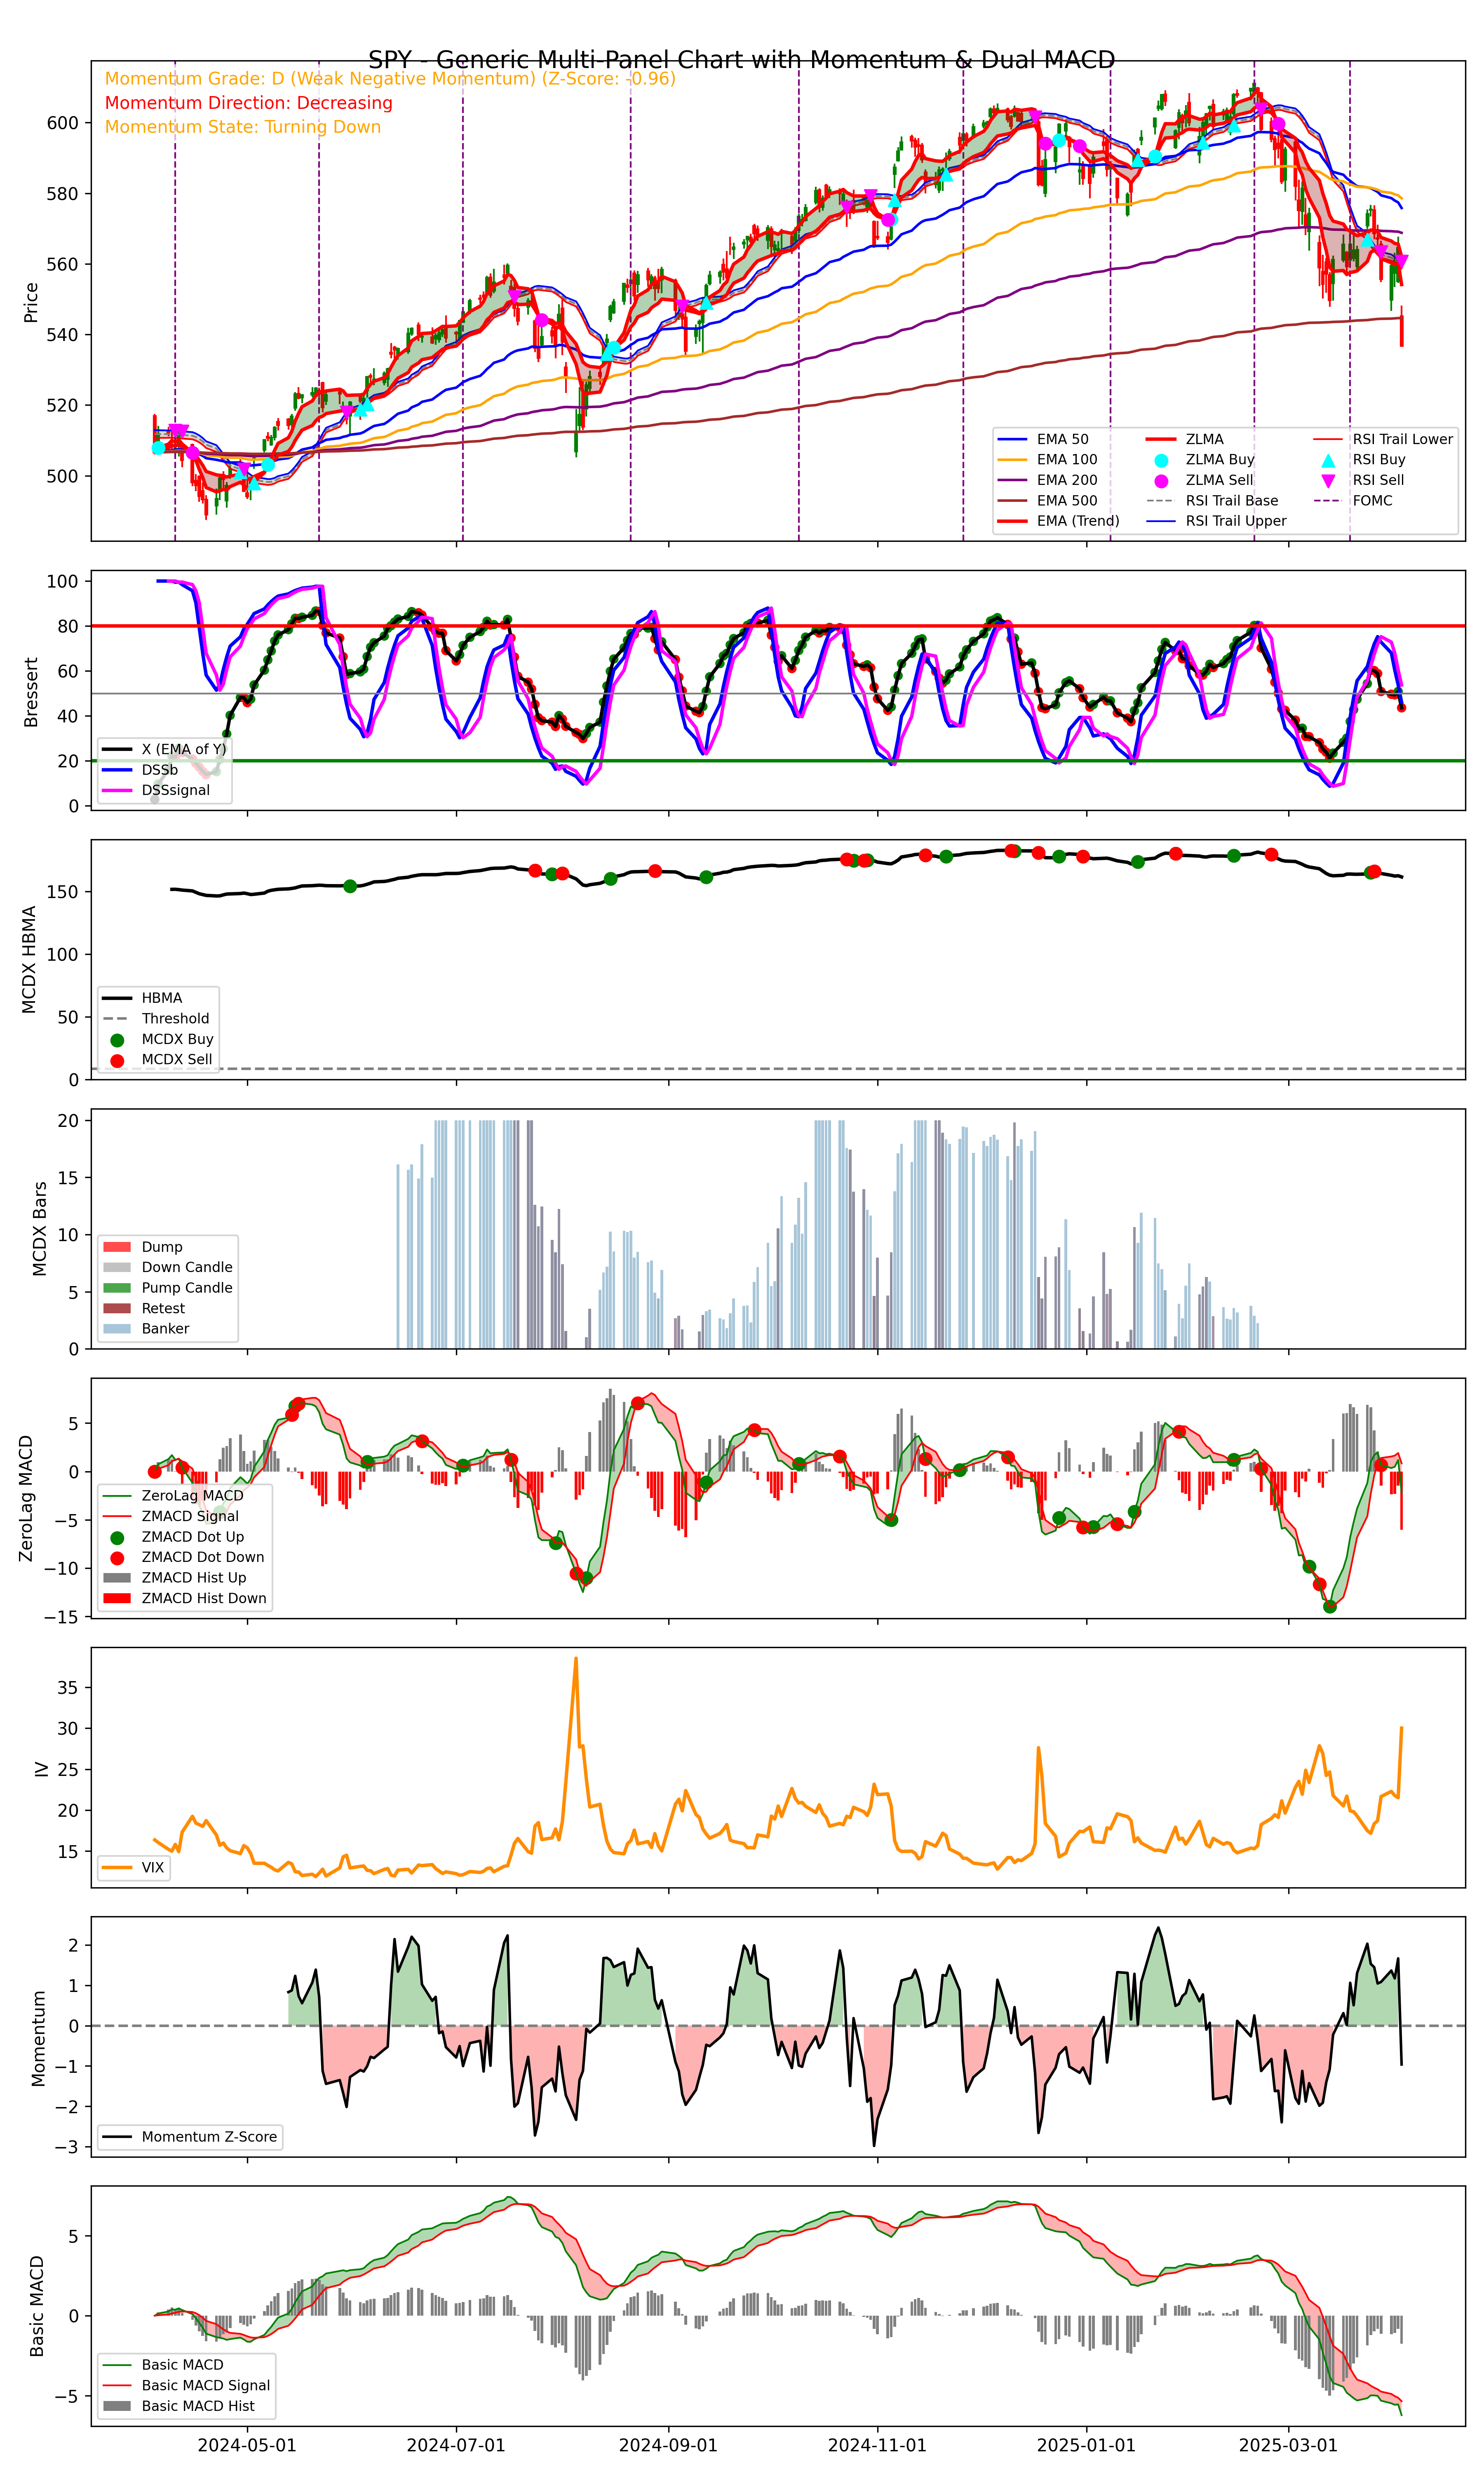

In [ ]:
from PIL import Image
from IPython.display import Image as IPyImage, display

img = "chart_output.png"
display(IPyImage(filename=img, width=900))

## Save Stuff (For Seed Searching)

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Import required before calling
from datetime import datetime

# Parameters
ticker = "NVDA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date      close       high        low       open     volume  \
0 2023-06-09  38.748840  39.689325  38.545952  39.015693  427717000   
1 2023-06-12  39.460457  39.508431  38.596930  39.178613  388701000   
2 2023-06-13  40.999619  41.078578  39.718320  40.164076  613208000   
3 2023-06-14  42.973545  42.976542  40.529875  40.801730  740465000   
4 2023-06-15  42.629730  43.265385  42.124006  42.578759  568622000   

      EMA_50    EMA_100    EMA_200    EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  38.748840  38.748840  38.748840  38.748840  ...         1         0   
1  38.776747  38.762932  38.755921  38.751681  ...         0         0   
2  38.863918  38.807223  38.778246  38.760655  ...         0         0   
3  39.025080  38.889724  38.819991  38.777473  ...         0         0   
4  39.166439  38.963784  38.857899  38.792851  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1        0         1                 0       

#

## Master Trading Env (Start Here)
Need to run this before anything else

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

SEED = 102022

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=0,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Total Reward: -5493.46
Final Balance: 6803.09
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-24     Long     45.4952    44.5877 -1.99   
1    2023-07-25  2023-07-27    Short     45.6541    45.8750 -0.48   
2    2023-07-28  2023-07-31    Short     46.7245    46.7035  0.04   
3    2023-08-01  2023-08-02     Long     46.4816    44.2449 -4.81   
4    2023-08-03  2023-08-04    Short     44.4907    44.6556 -0.37   
..          ...         ...      ...         ...        ...   ...   
178  2025-03-18  2025-03-19    Short    115.4300   117.5200 -1.78   
179  2025-03-20  2025-03-27    Short    118.5300   111.4300  6.37   
180  2025-03-27  2025-03-28     Long    111.4300   109.6700 -1.58   
181  2025-03-31  2025-04-01    Short    108.3800   110.1500 -1.61   
182  2025-04-01  2025-04-03     Long    110.1500   101.8000 -7.58   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0             -1.99          0.980053    

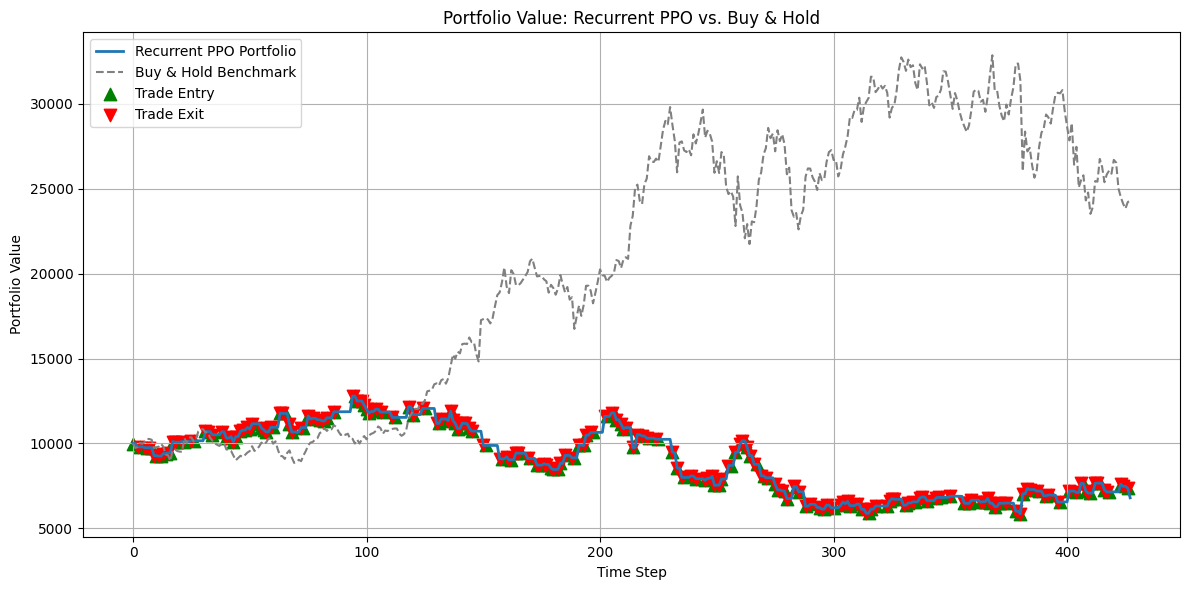

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## Fast Fixed Seed Search Above & Below (Find Seeds Here, Deterministic Start on Center Seed)

Fixed seed outputs centered around the main seed

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 49274
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # how far above/below to search

# --- Prepare Seed List ---
np.random.seed(CENTER_SEED)  # reproducible sweep

possible_below = np.arange(max(0, CENTER_SEED - SEED_RANGE), CENTER_SEED)
possible_above = np.arange(CENTER_SEED + 1, CENTER_SEED + SEED_RANGE)

n_below = (N_TRIALS - 1) // 2
n_above = N_TRIALS - 1 - n_below

below_seeds = np.random.choice(possible_below, size=n_below, replace=False)
above_seeds = np.random.choice(possible_above, size=n_above, replace=False)

all_seeds = [CENTER_SEED] + list(below_seeds) + list(above_seeds)
np.random.shuffle(all_seeds)  # optional: mix seed order

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # Re-init environment and model
    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=0,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.005
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

Streaming output truncated to the last 5000 lines.
|    approx_kl            | 1.3943762e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | -0.000221     |
|    learning_rate        | 0.0001        |
|    loss                 | 1.67e+05      |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.000142     |
|    value_loss           | 3.78e+05      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 99            |
|    iterations           | 4             |
|    time_elapsed         | 2             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 1.3038516e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss        

In [ ]:
# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")


--- Seed Sweep Complete ---
Best Seed: 17394
Best Total Reward: -11765.74
Best Final Balance: 10379.95


## Fixed Seed Search Random (Start Exactly on Center Seed)

Useful once you have a good seed to find better ones

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 112948
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # how far above/below to sample

# --- Prepare Seed List ---
possible_below = np.arange(max(0, CENTER_SEED - SEED_RANGE), CENTER_SEED)
possible_above = np.arange(CENTER_SEED + 1, CENTER_SEED + SEED_RANGE)

# Number of additional seeds
n_below = (N_TRIALS - 1) // 2
n_above = N_TRIALS - 1 - n_below

# Sample from below and above ranges
np.random.seed(None)  # randomize sweep on each run
below_seeds = np.random.choice(possible_below, size=n_below, replace=False)
above_seeds = np.random.choice(possible_above, size=n_above, replace=False)

# Combine all seeds, center first
remaining_seeds = list(below_seeds) + list(above_seeds)
np.random.shuffle(remaining_seeds)
all_seeds = [CENTER_SEED] + remaining_seeds

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=0, # Set to 1 to see the training log
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.005
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

In [ ]:
# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")

## True Random Seed Search (Actually Random)
Nothing works? Find a new seed

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 83819
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # max distance from center seed

# --- Prepare Random Seeds Around Center ---
low = max(0, CENTER_SEED - SEED_RANGE)
high = CENTER_SEED + SEED_RANGE

np.random.seed(None)  # ensure different results on each run
random_seeds = np.random.choice(np.arange(low, high), size=N_TRIALS, replace=False)

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in random_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=0,
        n_steps=64,
        batch_size=32,
        learning_rate=0.01,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    # Compute average reward per action
    avg_rewards = {}
    for action, rewards in env.reward_tracker.items():
        label = "Long" if action == 0 else "Short"
        avg = np.mean(rewards) if rewards else 0.0
        avg_rewards[label] = avg
        print(f"Average reward for action {label}: {avg:.4f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")


--- Training with seed 59945 ---
Seed 59945: Reward = 4603.65, Final Balance = 16611.51
Average reward for action Long: 0.2207
Average reward for action Short: -0.2924
Best model updated and saved.

--- Training with seed 35238 ---
Seed 35238: Reward = -5542.57, Final Balance = 6749.83
Average reward for action Long: 0.1086
Average reward for action Short: 0.0902

--- Training with seed 114865 ---
Seed 114865: Reward = -3284.99, Final Balance = 8733.03
Average reward for action Long: 0.4303
Average reward for action Short: -0.0503

--- Training with seed 78669 ---
Seed 78669: Reward = -2512.50, Final Balance = 9632.86
Average reward for action Long: 0.2388
Average reward for action Short: -0.0676

--- Training with seed 43151 ---
Seed 43151: Reward = -7168.18, Final Balance = 5077.19
Average reward for action Long: 0.6248
Average reward for action Short: -0.5181

--- Training with seed 43066 ---
Seed 43066: Reward = -3972.11, Final Balance = 8274.89
Average reward for action Long: 0.0

In [ ]:
# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")


--- Seed Sweep Complete ---
Best Seed: 59945
Best Total Reward: 4603.65
Best Final Balance: 16611.51


## Last Training on 4/3/2025

## GOOG

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "GOOG"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-09  122.290779  123.699110  121.842896  121.982235  20304500   
1 2023-06-12  123.763794  124.161910  121.773222  122.813294  22255700   
2 2023-06-13  123.843422  125.266681  123.261181  125.057672  19287700   
3 2023-06-14  123.793655  124.201726  121.584127  123.216395  24659600   
4 2023-06-15  125.197014  125.565272  122.559505  123.296014  24517100   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  122.290779  122.290779  122.290779  122.290779  ...         1         0   
1  122.348544  122.319948  122.305436  122.296659  ...         0         0   
2  122.407167  122.350116  122.320739  122.302834  ...         0         0   
3  122.461539  122.378700  122.335395  122.308785  ...         0         0   
4  122.568813  122.434509  122.363869  122.320315  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 98431
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 261 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 128         |
| train/                  |             |
|    approx_kl            | 0.016728982 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -1.1e-05    |
|    learning_rate        | 0.01        |
|    loss                 | 1.1e+04     |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.00104     |
|    value_loss           | 5.05e+04    |
-----------------------------------------
-----------------------

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: SELL
Total Reward: 4863.52
Final Balance: 16432.11
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-21     Long    118.9665   119.7428  0.65   
1    2023-07-24  2023-07-27     Long    121.3054   129.2578  6.56   
2    2023-07-28  2023-08-01    Short    132.3830   131.2682  0.85   
3    2023-08-02  2023-08-03     Long    128.0336   128.1630  0.10   
4    2023-08-04  2023-08-07     Long    127.9340   131.3180  2.65   
..          ...         ...      ...         ...        ...   ...   
170  2025-03-19  2025-03-20     Long    166.2800   165.0500 -0.74   
171  2025-03-21  2025-03-26    Short    166.2500   167.1400 -0.53   
172  2025-03-26  2025-03-27     Long    167.1400   164.0800 -1.83   
173  2025-03-27  2025-03-31    Short    164.0800   156.2300  5.02   
174  2025-04-01  2025-04-03    Short    158.8800   152.6300  4.09   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: SELL


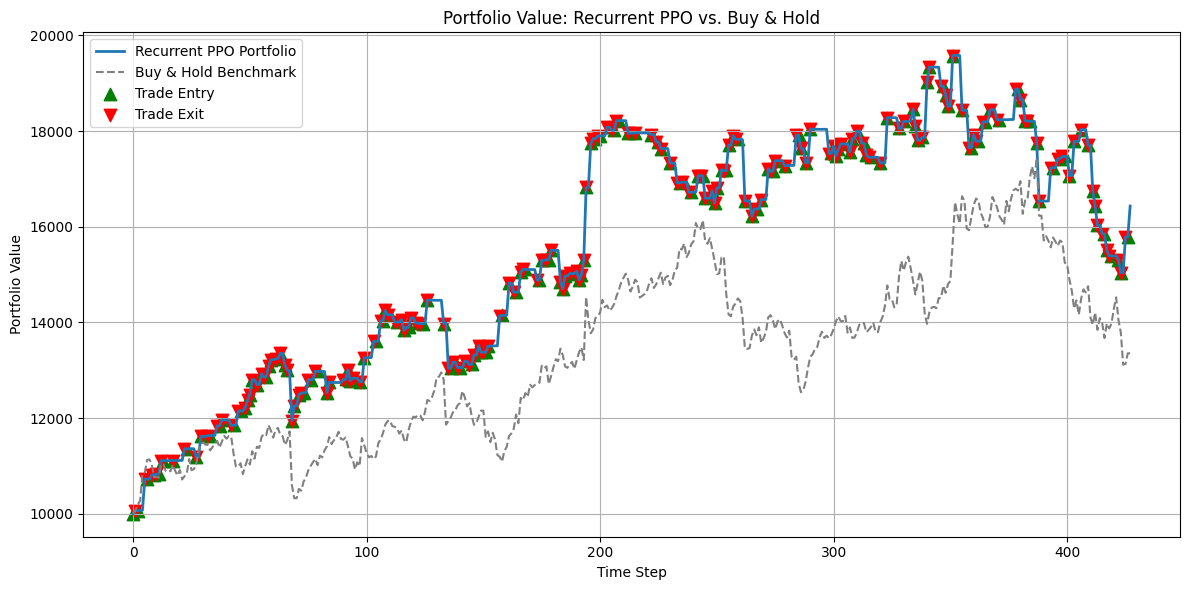

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

--- Training with seed 104764 ---
Seed 104764: Reward = -2986.21, Final Balance = 8888.63
Average reward for action Long: 0.0441
Average reward for action Short: 0.0332
Best model updated and saved.

--- Training with seed 105386 ---
Seed 105386: Reward = -1273.94, Final Balance = 10493.34
Average reward for action Long: -0.0675
Average reward for action Short: 0.0640
Best model updated and saved.

--- Training with seed 100838 ---
Seed 100838: Reward = -747.27, Final Balance = 11251.96
Average reward for action Long: -0.0345
Average reward for action Short: -0.2058
Best model updated and saved.

--- Training with seed 133184 ---
Seed 133184: Reward = -2683.32, Final Balance = 9382.98
Average reward for action Long: 0.0951
Average reward for action Short: -0.1814

--- Training with seed 98431 ---
Seed 98431: Reward = 4863.51, Final Balance = 16432.09
Average reward for action Long: 0.1471
Average reward for action Short: -0.1693
Best model updated and saved.

--- Training with seed 121805 ---
Seed 121805: Reward = -706.16, Final Balance = 11078.99
Average reward for action Long: -0.0095
Average reward for action Short: -0.1615

--- Training with seed 118082 ---
Seed 118082: Reward = -3173.14, Final Balance = 8608.41
Average reward for action Long: 0.0280
Average reward for action Short: -0.2828

--- Training with seed 88876 ---
Seed 88876: Reward = -5085.74, Final Balance = 7073.40
Average reward for action Long: -0.5438
Average reward for action Short: -0.2675

--- Training with seed 86580 ---
Seed 86580: Reward = -6453.47, Final Balance = 5553.40
Average reward for action Long: -0.2740
Average reward for action Short: -0.2159

--- Training with seed 113653 ---
Seed 113653: Reward = -264.01, Final Balance = 11553.68
Average reward for action Long: 0.0969
Average reward for action Short: 0.0462

--- Training with seed 98006 ---
Seed 98006: Reward = 3602.02, Final Balance = 15310.60
Average reward for action Long: 0.0290
Average reward for action Short: -0.1649

--- Seed Sweep Complete ---
Best Seed: 98431
Best Total Reward: 4863.51
Best Final Balance: 16432.09

In [ ]:
model.save("GOOG_best_model")

## AMZN

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "AMZN"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-09  123.430000  125.800003  123.190002  124.080002  51330000   
1 2023-06-12  126.570000  126.779999  123.529999  124.019997  51338000   
2 2023-06-13  126.660004  128.410004  125.180000  128.119995  50564800   
3 2023-06-14  126.419998  126.949997  124.120003  126.699997  52422500   
4 2023-06-15  127.110001  127.690002  124.320000  125.209999  60458500   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  123.430000  123.430000  123.430000  123.430000  ...         1         0   
1  123.553138  123.492179  123.461244  123.442535  ...         0         0   
2  123.674975  123.554908  123.493073  123.455379  ...         0         0   
3  123.782623  123.611642  123.522196  123.467214  ...         0         0   
4  123.913109  123.680917  123.557896  123.481756  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 100184
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 236 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 128         |
| train/                  |             |
|    approx_kl            | 0.017180637 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -0.000154   |
|    learning_rate        | 0.01        |
|    loss                 | 1.14e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00618    |
|    value_loss           | 1.98e+05    |
-----------------------------------------
-----------------------

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: SELL
Total Reward: 14552.65
Final Balance: 26138.38
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-21    Short      129.96     130.00 -0.03   
1    2023-07-24  2023-07-26    Short      128.80     128.15  0.51   
2    2023-07-27  2023-08-02    Short      128.25     128.21  0.03   
3    2023-08-03  2023-08-04     Long      128.91     139.57  8.27   
4    2023-08-07  2023-08-11    Short      142.22     138.41  2.75   
..          ...         ...      ...         ...        ...   ...   
172  2025-03-24  2025-03-26    Short      203.26     201.13  1.06   
173  2025-03-26  2025-03-27     Long      201.13     201.36  0.11   
174  2025-03-28  2025-03-31    Short      192.72     190.26  1.29   
175  2025-03-31  2025-04-01     Long      190.26     192.17  1.00   
176  2025-04-02  2025-04-03    Short      196.01     178.41  9.86   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  


In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: SELL


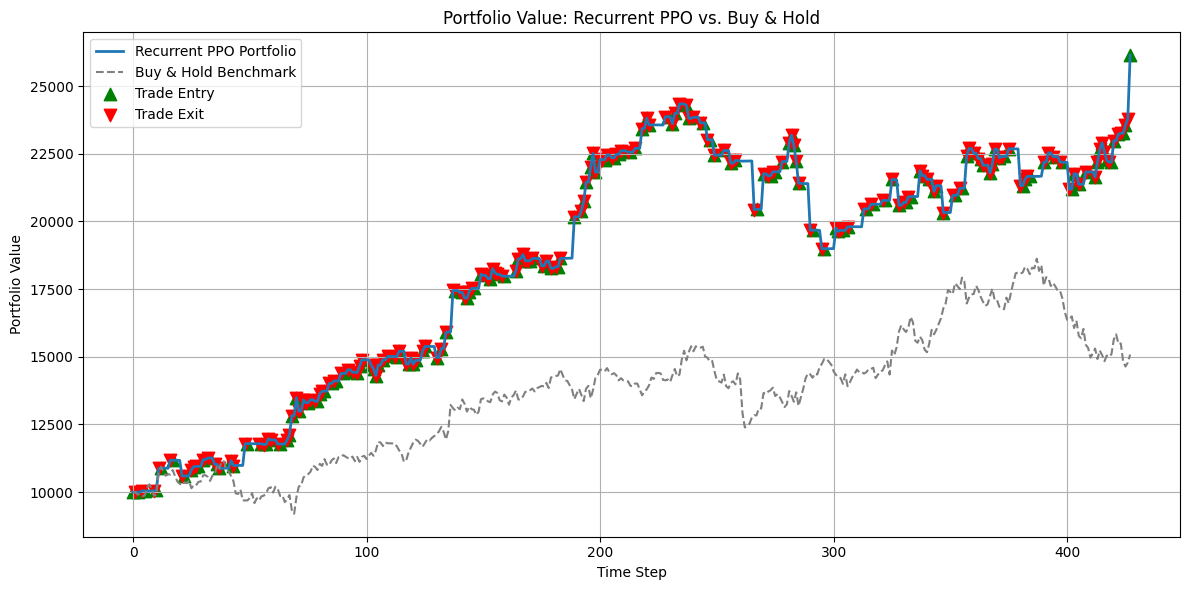

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

--- Training with seed 46952 ---
Seed 46952: Reward = -5086.40, Final Balance = 6910.91
Average reward for action Long: -0.1057
Average reward for action Short: -0.4763
Best model updated and saved.

--- Training with seed 53568 ---
Seed 53568: Reward = -4397.62, Final Balance = 7551.44
Average reward for action Long: 0.0977
Average reward for action Short: -0.4755
Best model updated and saved.

--- Training with seed 92316 ---
Seed 92316: Reward = -763.24, Final Balance = 11090.56
Average reward for action Long: 0.2928
Average reward for action Short: -0.0790
Best model updated and saved.

--- Training with seed 58034 ---
Seed 58034: Reward = -1859.75, Final Balance = 10072.37
Average reward for action Long: 0.0907
Average reward for action Short: 0.0506

--- Training with seed 100184 ---
Seed 100184: Reward = 4765.20, Final Balance = 16462.39
Average reward for action Long: 0.0220
Average reward for action Short: -0.1291
Best model updated and saved.

--- Training with seed 130782 ---
Seed 130782: Reward = 942.60, Final Balance = 12799.14
Average reward for action Long: 0.2607
Average reward for action Short: -0.1698

--- Training with seed 111062 ---
Seed 111062: Reward = -609.30, Final Balance = 11101.10
Average reward for action Long: 0.4497
Average reward for action Short: -0.2982

--- Training with seed 47466 ---
Seed 47466: Reward = -5503.50, Final Balance = 6326.15
Average reward for action Long: 0.2019
Average reward for action Short: -0.2887

--- Training with seed 56250 ---
Seed 56250: Reward = -5608.07, Final Balance = 6389.03
Average reward for action Long: -0.0549
Average reward for action Short: -0.0476

--- Training with seed 58437 ---
Seed 58437: Reward = -5742.72, Final Balance = 6262.94
Average reward for action Long: -0.0178
Average reward for action Short: -0.2787

--- Training with seed 65132 ---
Seed 65132: Reward = 305.88, Final Balance = 12086.73
Average reward for action Long: 0.1462
Average reward for action Short: -0.0675

--- Seed Sweep Complete ---
Best Seed: 100184
Best Total Reward: 4765.20
Best Final Balance: 16462.39

In [ ]:
model.save("AMZN_best_model")

## AAPL

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "AAPL"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-09  179.401093  180.660141  179.073934  179.936434  48870700   
1 2023-06-12  182.206711  182.305855  179.411012  179.708431  54274900   
2 2023-06-13  181.730820  182.563580  180.868319  181.225219  54929100   
3 2023-06-14  182.365356  182.801568  180.451990  181.790351  57462900   
4 2023-06-15  184.407578  184.913194  182.196792  182.375250  65433200   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  179.401093  179.401093  179.401093  179.401093  ...         1         0   
1  179.511117  179.456649  179.429009  179.412293  ...         0         0   
2  179.598164  179.501682  179.451913  179.421548  ...         0         0   
3  179.706681  179.558389  179.480902  179.433300  ...         0         0   
4  179.891030  179.654412  179.529924  179.453157  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 119045
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 236 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 128         |
| train/                  |             |
|    approx_kl            | 0.038925402 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | 0.000255    |
|    learning_rate        | 0.01        |
|    loss                 | 2.54e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.00639     |
|    value_loss           | 6.18e+04    |
-----------------------------------------
-----------------------

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: BUY
Total Reward: 4147.36
Final Balance: 15808.03
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-26     Long    191.4663   192.8244  0.71   
1    2023-07-27  2023-07-28    Short    191.5555   194.1430 -1.33   
2    2023-07-31  2023-08-02    Short    194.7576   190.9210  2.01   
3    2023-08-03  2023-08-04     Long    189.5231   180.4222 -4.80   
4    2023-08-07  2023-08-08     Long    177.3093   178.2511  0.53   
..          ...         ...      ...         ...        ...   ...   
180  2025-03-18  2025-03-19     Long    212.6900   215.2400  1.20   
181  2025-03-19  2025-03-20    Short    215.2400   214.1000  0.53   
182  2025-03-21  2025-03-26    Short    218.2700   221.5300 -1.47   
183  2025-03-27  2025-04-01     Long    223.8500   223.1900 -0.29   
184  2025-04-02  2025-04-03     Long    223.8900   203.1900 -9.25   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0 

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: BUY


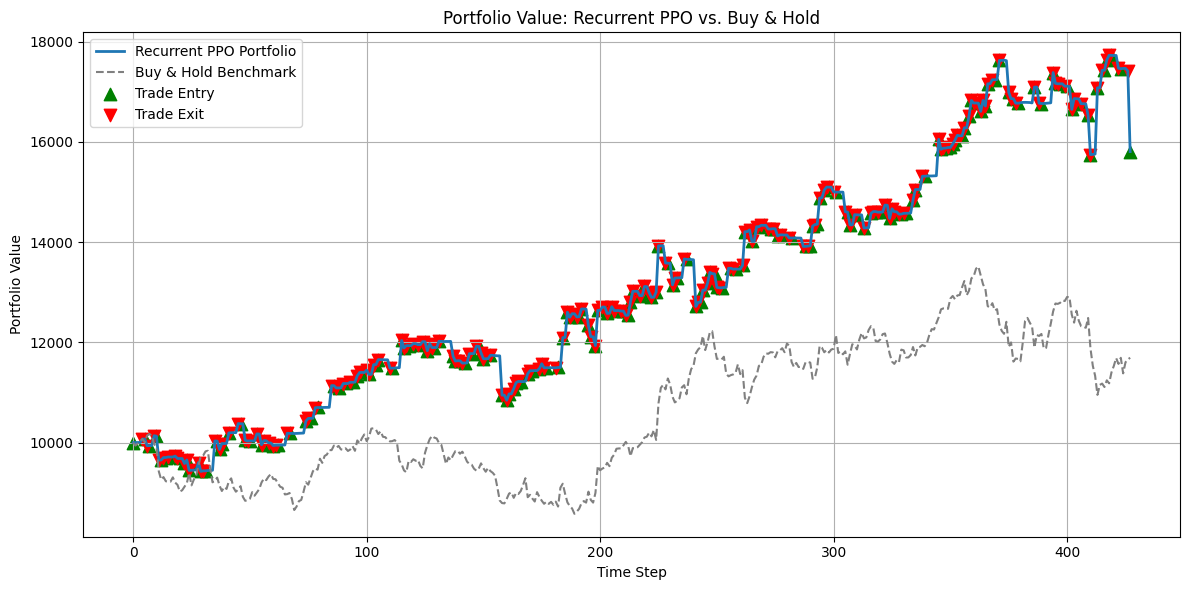

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

--- Training with seed 34416 ---
Seed 34416: Reward = -4085.96, Final Balance = 7544.23
Average reward for action Long: 0.1480
Average reward for action Short: -0.1387
Best model updated and saved.

--- Training with seed 100397 ---
Seed 100397: Reward = 3491.85, Final Balance = 15036.42
Average reward for action Long: 0.3199
Average reward for action Short: -0.2669
Best model updated and saved.

--- Training with seed 67392 ---
Seed 67392: Reward = -1867.09, Final Balance = 9965.78
Average reward for action Long: -0.0217
Average reward for action Short: -0.2089

--- Training with seed 102984 ---
Seed 102984: Reward = -748.14, Final Balance = 10939.37
Average reward for action Long: 0.1519
Average reward for action Short: 0.2305

--- Training with seed 84021 ---
Seed 84021: Reward = 216.71, Final Balance = 12068.85
Average reward for action Long: -0.0994
Average reward for action Short: -0.2542

--- Training with seed 102423 ---
Seed 102423: Reward = -479.92, Final Balance = 11069.34
Average reward for action Long: -0.2407
Average reward for action Short: -0.3002

--- Training with seed 85753 ---
Seed 85753: Reward = -5169.83, Final Balance = 6732.26
Average reward for action Long: 0.1386
Average reward for action Short: 0.1133

--- Training with seed 125247 ---
Seed 125247: Reward = 1207.04, Final Balance = 12800.83
Average reward for action Long: 0.3657
Average reward for action Short: 0.2077

--- Training with seed 119045 ---
Seed 119045: Reward = 4147.36, Final Balance = 15808.03
Average reward for action Long: 0.0472
Average reward for action Short: 0.0258
Best model updated and saved.

--- Training with seed 104939 ---
Seed 104939: Reward = -214.68, Final Balance = 11283.91
Average reward for action Long: -0.1409
Average reward for action Short: 0.1132

--- Training with seed 95743 ---
Seed 95743: Reward = -2052.15, Final Balance = 9737.26
Average reward for action Long: 0.2132
Average reward for action Short: -0.1212

--- Seed Sweep Complete ---
Best Seed: 119045
Best Total Reward: 4147.36
Best Final Balance: 15808.03

In [ ]:
model.save("AAPL_best_model")

## META

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "META"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-09  263.707123  266.693050  260.472369  261.248708  16938500   
1 2023-06-12  269.778534  270.475262  264.085364  265.916760  15442500   
2 2023-06-13  270.047302  274.426657  267.827752  273.590601  16164000   
3 2023-06-14  272.067749  273.700040  267.061345  270.614606  19175100   
4 2023-06-15  280.507965  282.657837  270.146824  271.022670  25973500   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  263.707123  263.707123  263.707123  263.707123  ...         1         0   
1  263.945217  263.827349  263.767535  263.731360  ...         0         0   
2  264.184515  263.950516  263.830020  263.756573  ...         0         0   
3  264.493661  264.111253  263.911988  263.789752  ...         0         0   
4  265.121673  264.435941  264.077122  263.856491  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 54833
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 257 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0011567045 |
|    clip_fraction        | 0.231        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.682       |
|    explained_variance   | 0.000109     |
|    learning_rate        | 0.01         |
|    loss                 | 5.36e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | 0.00269      |
|    value_loss           | 8.27e+04     |
------------------------------------------
-----

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: SELL
Total Reward: 9595.11
Final Balance: 21099.37
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-20  2023-07-24    Short    301.1009   290.2421   3.74   
1    2023-07-25  2023-07-28     Long    293.0887   323.9532  10.53   
2    2023-07-31  2023-08-09     Long    317.1055   303.7783  -4.20   
3    2023-08-09  2023-08-11    Short    303.7783   300.2251   1.18   
4    2023-08-11  2023-08-14     Long    300.2251   304.7537   1.51   
..          ...         ...      ...         ...        ...    ...   
171  2025-03-10  2025-03-18     Long    597.4584   582.3600  -2.53   
172  2025-03-18  2025-03-20    Short    582.3600   586.0000  -0.62   
173  2025-03-21  2025-03-25     Long    596.2500   626.3100   5.04   
174  2025-03-26  2025-03-28     Long    610.9800   576.7400  -5.60   
175  2025-03-28  2025-04-02    Short    576.7400   583.9300  -1.23   

     CumulativePnL%  CompoundedFactor  Compou

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: SELL


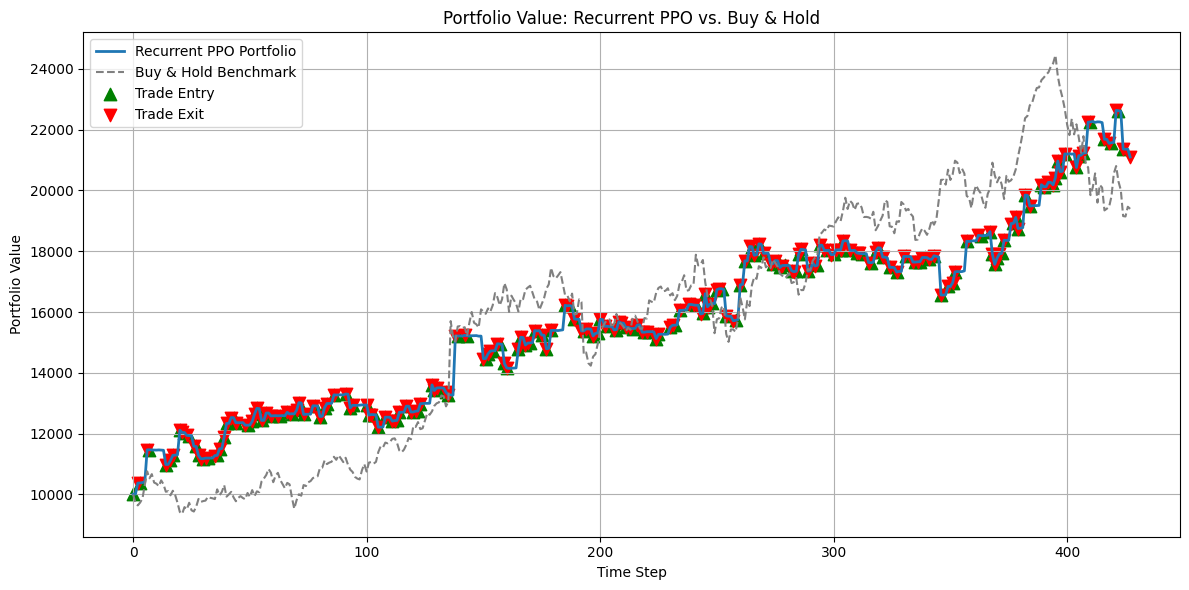

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

--- Training with seed 125220 ---
Seed 125220: Reward = -3345.66, Final Balance = 8474.43
Average reward for action Long: 0.3245
Average reward for action Short: -0.3909
Best model updated and saved.

--- Training with seed 100208 ---
Seed 100208: Reward = -6324.62, Final Balance = 5671.42
Average reward for action Long: -0.5764
Average reward for action Short: -0.3756

--- Training with seed 69078 ---
Seed 69078: Reward = 1158.07, Final Balance = 12632.76
Average reward for action Long: 0.5058
Average reward for action Short: 0.2562
Best model updated and saved.

--- Training with seed 82117 ---
Seed 82117: Reward = 3322.67, Final Balance = 14924.58
Average reward for action Long: -0.0088
Average reward for action Short: 0.0007
Best model updated and saved.

--- Training with seed 93593 ---
Seed 93593: Reward = 11716.28, Final Balance = 23084.90
Average reward for action Long: 0.3899
Average reward for action Short: 0.1358
Best model updated and saved.

--- Training with seed 116216 ---
Seed 116216: Reward = -1368.56, Final Balance = 10504.17
Average reward for action Long: 0.1256
Average reward for action Short: -0.2843

--- Training with seed 51779 ---
Seed 51779: Reward = 516.23, Final Balance = 12247.59
Average reward for action Long: 0.2061
Average reward for action Short: -0.1145

--- Training with seed 117639 ---
Seed 117639: Reward = 4289.68, Final Balance = 15720.86
Average reward for action Long: 0.3138
Average reward for action Short: 0.3791

--- Training with seed 67710 ---
Seed 67710: Reward = -5154.42, Final Balance = 6926.39
Average reward for action Long: -0.1138
Average reward for action Short: -0.3724

--- Training with seed 69515 ---
Seed 69515: Reward = -4361.47, Final Balance = 7862.33
Average reward for action Long: 0.0379
Average reward for action Short: -0.2043

--- Training with seed 101986 ---
Seed 101986: Reward = 3751.45, Final Balance = 15196.55
Average reward for action Long: 0.4274
Average reward for action Short: 0.0246

--- Seed Sweep Complete ---
Best Seed: 93593
Best Total Reward: 11716.28
Best Final Balance: 23084.90

______________________________________________________

--- Training with seed 88598 ---
Seed 88598: Reward = 7851.90, Final Balance = 19476.58
Average reward for action Long: 0.5704
Average reward for action Short: -0.0076
Best model updated and saved.

--- Training with seed 57422 ---
Seed 57422: Reward = -270.99, Final Balance = 11127.97
Average reward for action Long: 0.6221
Average reward for action Short: -0.1573

--- Training with seed 99487 ---
Seed 99487: Reward = 804.62, Final Balance = 12467.88
Average reward for action Long: -0.0027
Average reward for action Short: -0.3653

--- Training with seed 103399 ---
Seed 103399: Reward = -4463.43, Final Balance = 7690.57
Average reward for action Long: -0.1914
Average reward for action Short: 0.2768

--- Training with seed 120699 ---
Seed 120699: Reward = -4681.46, Final Balance = 7400.93
Average reward for action Long: 0.2829
Average reward for action Short: 0.1421

--- Training with seed 108445 ---
Seed 108445: Reward = -2689.08, Final Balance = 9181.68
Average reward for action Long: 0.1319
Average reward for action Short: 0.0110

--- Training with seed 54833 ---
Seed 54833: Reward = 9595.12, Final Balance = 21099.38
Average reward for action Long: 0.2197
Average reward for action Short: 0.0768
Best model updated and saved.

--- Training with seed 73431 ---
Seed 73431: Reward = -4779.87, Final Balance = 7091.03
Average reward for action Long: -0.0301
Average reward for action Short: -0.0755

--- Training with seed 107606 ---
Seed 107606: Reward = -3551.91, Final Balance = 8333.85
Average reward for action Long: 0.4491
Average reward for action Short: -0.3601

--- Training with seed 36388 ---
Seed 36388: Reward = -837.69, Final Balance = 10870.25
Average reward for action Long: 0.2350
Average reward for action Short: -0.4474

--- Training with seed 101620 ---
Seed 101620: Reward = -2581.42, Final Balance = 9317.52
Average reward for action Long: 0.0712
Average reward for action Short: 0.0892

--- Seed Sweep Complete ---
Best Seed: 54833
Best Total Reward: 9595.12
Best Final Balance: 21099.38

In [ ]:
model.save("META_best_model")

## MSFT

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "MSFT"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-09  322.377136  325.533906  320.029270  320.601425  22514900   
1 2023-06-12  327.368744  327.615368  320.769082  324.142882  24260300   
2 2023-06-13  329.775848  332.429526  325.928519  329.953410  22951300   
3 2023-06-14  332.784637  334.461693  328.315811  329.825149  26003800   
4 2023-06-15  343.399353  345.115847  332.646550  332.922768  38899100   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  322.377136  322.377136  322.377136  322.377136  ...         1         0   
1  322.572886  322.475980  322.426804  322.397063  ...         0         0   
2  322.855355  322.620532  322.499929  322.426519  ...         0         0   
3  323.244738  322.821801  322.602264  322.467869  ...         0         0   
4  324.035115  323.229277  322.809200  322.551428  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 80798
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 256 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0015379209 |
|    clip_fraction        | 0.2          |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.682       |
|    explained_variance   | -2.12e-05    |
|    learning_rate        | 0.01         |
|    loss                 | 8.35e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | 0.00198      |
|    value_loss           | 1.34e+05     |
------------------------------------------
-----

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: BUY
Total Reward: -339.07
Final Balance: 11332.32
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-24     Long    342.1859   340.4497 -0.51   
1    2023-07-25  2023-07-27    Short    346.2405   326.2540  6.13   
2    2023-07-28  2023-07-31    Short    333.8008   331.3839  0.73   
3    2023-08-01  2023-08-02     Long    331.7982   323.0775 -2.63   
4    2023-08-03  2023-08-04    Short    322.2489   323.3537 -0.34   
..          ...         ...      ...         ...        ...   ...   
173  2025-03-18  2025-03-19    Short    383.5200   387.8200 -1.11   
174  2025-03-19  2025-03-20     Long    387.8200   386.8400 -0.25   
175  2025-03-21  2025-03-27    Short    391.2600   390.5800  0.17   
176  2025-03-28  2025-04-01    Short    378.8000   382.1900 -0.89   
177  2025-04-01  2025-04-03     Long    382.1900   373.1100 -2.38   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0 

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: BUY


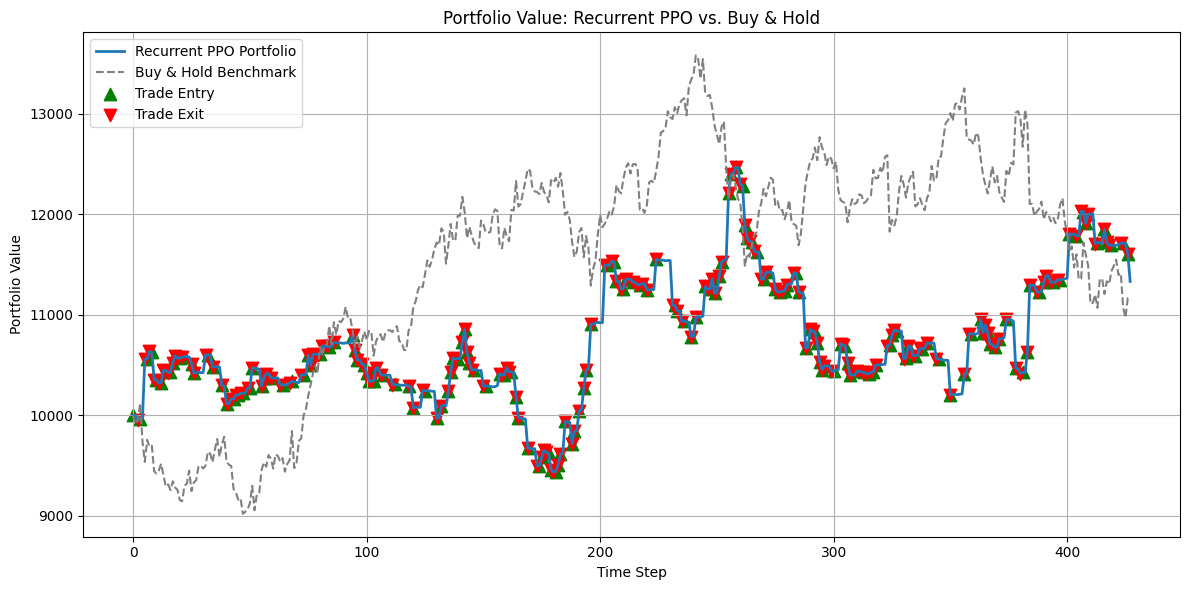

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

--- Training with seed 124156 ---
Seed 124156: Reward = -3485.42, Final Balance = 8336.80
Average reward for action Long: 0.0056
Average reward for action Short: -0.2009
Best model updated and saved.

--- Training with seed 92334 ---
Seed 92334: Reward = -5085.15, Final Balance = 7125.97
Average reward for action Long: 0.4129
Average reward for action Short: -0.4937

--- Training with seed 130729 ---
Seed 130729: Reward = 1813.04, Final Balance = 13823.87
Average reward for action Long: -0.0476
Average reward for action Short: -0.1514
Best model updated and saved.

--- Training with seed 68392 ---
Seed 68392: Reward = -4926.16, Final Balance = 7129.17
Average reward for action Long: -0.0547
Average reward for action Short: -0.1424

--- Training with seed 72083 ---
Seed 72083: Reward = 1020.91, Final Balance = 12851.05
Average reward for action Long: 0.1237
Average reward for action Short: -0.1989

--- Training with seed 72483 ---
Seed 72483: Reward = -1815.11, Final Balance = 10153.02
Average reward for action Long: 0.2375
Average reward for action Short: -0.3650

--- Training with seed 80529 ---
Seed 80529: Reward = -70.94, Final Balance = 11571.10
Average reward for action Long: 0.1580
Average reward for action Short: 0.1158

--- Training with seed 90915 ---
Seed 90915: Reward = -6938.25, Final Balance = 5102.15
Average reward for action Long: -0.2096
Average reward for action Short: -0.5916

--- Training with seed 102022 ---
Seed 102022: Reward = 2483.09, Final Balance = 14280.24
Average reward for action Long: 0.3833
Average reward for action Short: -0.2833
Best model updated and saved.

--- Training with seed 36107 ---
Seed 36107: Reward = -4947.28, Final Balance = 6986.78
Average reward for action Long: 0.2313
Average reward for action Short: -0.3475

--- Training with seed 33824 ---
Seed 33824: Reward = -2129.68, Final Balance = 9778.37
Average reward for action Long: -0.2481
Average reward for action Short: -0.5245

--- Seed Sweep Complete ---
Best Seed: 102022
Best Total Reward: 2483.09
Best Final Balance: 14280.24

In [ ]:
model.save("MSFT_best_model")

## NVDA

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "NVDA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date      close       high        low       open     volume  \
0 2023-06-09  38.748844  39.689329  38.545956  39.015697  427717000   
1 2023-06-12  39.460457  39.508431  38.596930  39.178613  388701000   
2 2023-06-13  40.999615  41.078574  39.718317  40.164072  613208000   
3 2023-06-14  42.973541  42.976538  40.529872  40.801727  740465000   
4 2023-06-15  42.629730  43.265385  42.124006  42.578759  568622000   

      EMA_50    EMA_100    EMA_200    EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  38.748844  38.748844  38.748844  38.748844  ...         1         0   
1  38.776751  38.762935  38.755925  38.751685  ...         0         0   
2  38.863922  38.807226  38.778250  38.760659  ...         0         0   
3  39.025083  38.889727  38.819994  38.777477  ...         0         0   
4  39.166442  38.963787  38.857902  38.792855  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1        0         1                 0       

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 112948
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 267 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 128        |
| train/                  |            |
|    approx_kl            | 0.01993292 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.68      |
|    explained_variance   | -0.000163  |
|    learning_rate        | 0.01       |
|    loss                 | 2.55e+05   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00569   |
|    value_loss           | 3.09e+05   |
----------------------------------------
-----------------------------------------

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: SELL
Total Reward: 1575.74
Final Balance: 13757.50
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-25     Long     45.4952    45.6541  0.35   
1    2023-07-26  2023-07-27    Short     45.4272    45.8750 -0.98   
2    2023-07-28  2023-08-03     Long     46.7245    44.4907 -4.78   
3    2023-08-04  2023-08-07     Long     44.6556    45.3922  1.65   
4    2023-08-08  2023-08-10    Short     44.6396    42.3649  5.37   
..          ...         ...      ...         ...        ...   ...   
177  2025-03-24  2025-03-25    Short    121.4100   120.6900  0.60   
178  2025-03-26  2025-03-27    Short    113.7600   111.4300  2.09   
179  2025-03-27  2025-03-28     Long    111.4300   109.6700 -1.58   
180  2025-03-31  2025-04-01     Long    108.3800   110.1500  1.63   
181  2025-04-01  2025-04-02    Short    110.1500   110.4200 -0.24   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: SELL


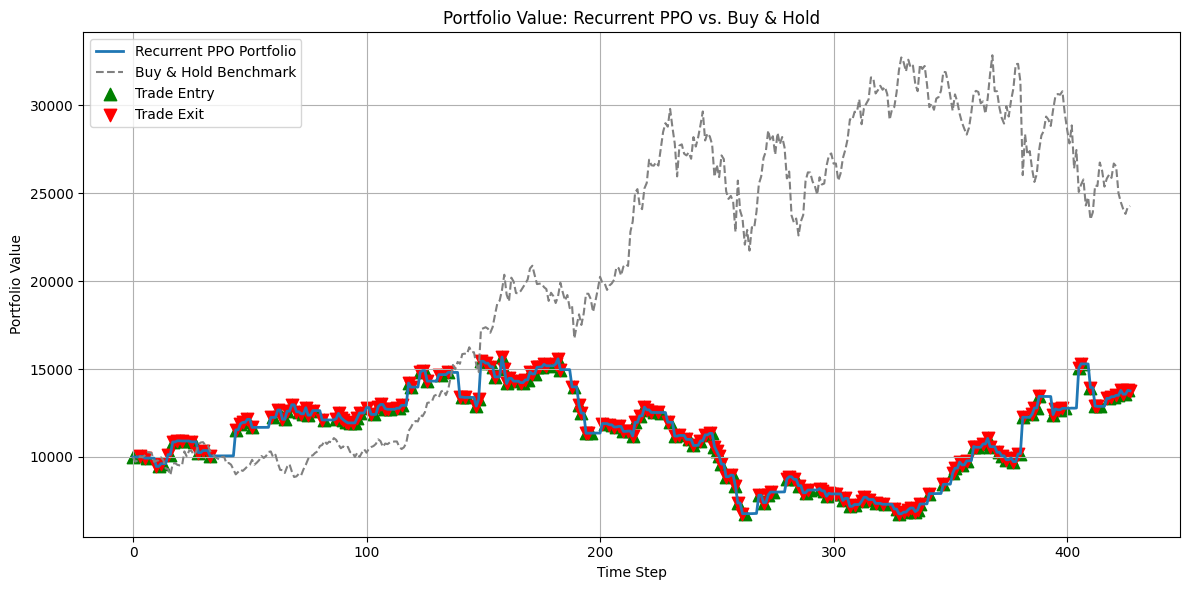

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()


--- Training with seed 91571 ---
Seed 91571: Reward = -4037.79, Final Balance = 7796.75
Average reward for action Long: 0.3437
Average reward for action Short: -0.4807
Best model updated and saved.

--- Training with seed 79322 ---
Seed 79322: Reward = -1410.71, Final Balance = 10570.23
Average reward for action Long: -0.0702
Average reward for action Short: -0.0866
Best model updated and saved.

--- Training with seed 73389 ---
Seed 73389: Reward = -1780.88, Final Balance = 10108.38
Average reward for action Long: -0.1103
Average reward for action Short: -0.0284

--- Training with seed 37102 ---
Seed 37102: Reward = -3473.91, Final Balance = 8051.82
Average reward for action Long: -0.1424
Average reward for action Short: -0.3177

--- Training with seed 114356 ---
Seed 114356: Reward = -4136.27, Final Balance = 7747.00
Average reward for action Long: 0.0798
Average reward for action Short: -0.3700

--- Training with seed 80798 ---
Seed 80798: Reward = 365.87, Final Balance = 11963.70
Average reward for action Long: 0.2393
Average reward for action Short: 0.0899
Best model updated and saved.

--- Training with seed 122794 ---
Seed 122794: Reward = -2148.59, Final Balance = 9324.05
Average reward for action Long: 0.1287
Average reward for action Short: -0.2701

--- Training with seed 105274 ---
Seed 105274: Reward = -1727.42, Final Balance = 9799.28
Average reward for action Long: -0.0994
Average reward for action Short: -0.3179

--- Training with seed 78100 ---
Seed 78100: Reward = -2796.62, Final Balance = 8955.31
Average reward for action Long: -0.1910
Average reward for action Short: 0.0132

--- Training with seed 96302 ---
Seed 96302: Reward = -2315.93, Final Balance = 9269.41
Average reward for action Long: -0.0423
Average reward for action Short: -0.4318

--- Training with seed 102353 ---
Seed 102353: Reward = -2696.56, Final Balance = 8934.61
Average reward for action Long: 0.0921
Average reward for action Short: 0.1157

--- Seed Sweep Complete ---
Best Seed: 80798
Best Total Reward: 365.87
Best Final Balance: 11963.70

In [ ]:
model.save("NVDA_best_model")

## NVDA Momentum Test

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "NVDA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date      close       high        low       open     volume  \
0 2023-06-09  38.748848  39.689333  38.545960  39.015701  427717000   
1 2023-06-12  39.460453  39.508427  38.596926  39.178609  388701000   
2 2023-06-13  40.999615  41.078574  39.718317  40.164072  613208000   
3 2023-06-14  42.973541  42.976538  40.529872  40.801727  740465000   
4 2023-06-15  42.629730  43.265385  42.124006  42.578759  568622000   

      EMA_50    EMA_100    EMA_200    EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  38.748848  38.748848  38.748848  38.748848  ...         1         0   
1  38.776754  38.762939  38.755929  38.751689  ...         0         0   
2  38.863925  38.807230  38.778254  38.760662  ...         0         0   
3  39.025086  38.889731  38.819998  38.777480  ...         0         0   
4  39.166445  38.963790  38.857906  38.792859  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1        0         1                 0       

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 112948
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75,
                 drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        hold_feature = np.array([self.hold_counter], dtype=np.float32)
        obs = np.concatenate([features, pos_feature, hold_feature])
        return np.nan_to_num(obs, nan=0.0, posinf=1e6, neginf=-1e6)

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        gross_return = trade_pct / 100
        pos_str = 'Long' if self.position == 1 else 'Short'

        old_balance = self.balance
        transaction_cost = TRANSACTION_COST * current_price
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance
        reward = net_profit

        if 0 < abs(trade_pct) < 0.3:
            reward -= (0.3 - abs(trade_pct)) ** 2 * 2

        if trade_pct < self.large_loss_threshold:
            reward += trade_pct * 2

        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * self.loss_penalty
        else:
            self.consecutive_losses = 0

        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= self.drawdown_penalty * drawdown

        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        reward = np.clip(reward, -100, 100)
        self.step_rewards.append(reward)
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost

            if self.hold_counter >= 5 and step_return > 0:
                step_reward += min(step_return * 5, 5)

            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            entry_penalty = TRANSACTION_COST * current_price
            reward -= entry_penalty

        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = min(10.0, self.switch_cost + hold_penalty)
            reward += self._force_close()
            reward -= switch_penalty

            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)
                reentry_threshold = 0.5 * row['volatility'] if self.dynamic_threshold else self.reentry_threshold
            else:
                recent_return = 0
                reentry_threshold = 0.01

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        if len(self.step_rewards) >= 5:
            recent_std = np.std(self.step_rewards[-5:])
            if recent_std < 20:
                reward += 10

        reward = np.clip(reward, -100, 100)
        self.step_rewards.append(reward)

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=512,
    batch_size=64,
    learning_rate=0.005,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=10000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 223 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 2          |
|    time_elapsed         | 8          |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.03617235 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.679     |
|    explained_variance   | 0.000102   |
|    learning_rate        | 0.005      |
|    loss                 | 1.87e+04   |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.00628    |
|    value_loss           | 2.88e+04   |
----------------------------------------
----------------------------------------


In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: SELL
Total Reward: -671.65
Final Balance: 9676.35
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-20  2023-07-21    Short     45.4952    44.2848  2.73   
1    2023-07-21  2023-07-27     Long     44.2848    45.8750  3.59   
2    2023-07-28  2023-07-31    Short     46.7245    46.7035  0.04   
3    2023-08-01  2023-08-04    Short     46.4816    44.6556  4.09   
4    2023-08-07  2023-08-09     Long     45.3922    42.5308 -6.30   
..          ...         ...      ...         ...        ...   ...   
186  2025-03-21  2025-03-26    Short    117.7000   113.7600  3.46   
187  2025-03-26  2025-03-28     Long    113.7600   109.6700 -3.60   
188  2025-03-28  2025-03-31    Short    109.6700   108.3800  1.19   
189  2025-03-31  2025-04-01     Long    108.3800   110.1500  1.63   
190  2025-04-01  2025-04-03    Short    110.1500   101.8000  8.20   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0 

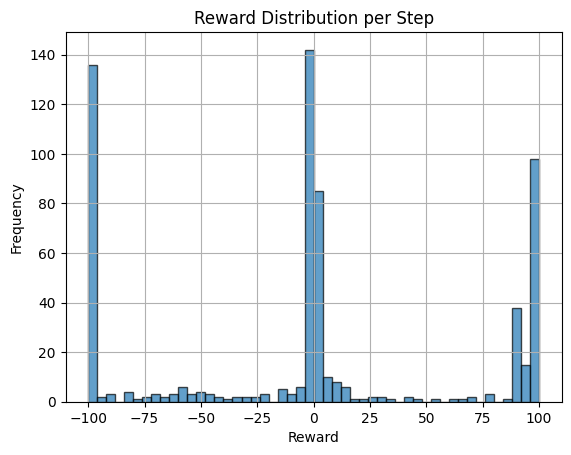

Step Reward Mean: -1.1775
Step Reward Std Dev: 69.7704
Step Reward Variance: 4867.9120
Reward Percentiles (5/25/50/75/95): [-1.00000000e+02 -6.13381107e+01 -8.63736191e-02  7.33740447e+01
  1.00000000e+02]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rewards = np.array(env.step_rewards)  # <- make sure this was filled in step()

if len(rewards) == 0:
    print("No rewards recorded. Make sure to populate env.step_rewards during evaluation.")
else:
    # Plot histogram
    plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
    plt.title("Reward Distribution per Step")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Compute statistics
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    reward_variance = np.var(rewards)
    percentiles = np.percentile(rewards, [5, 25, 50, 75, 95])

    print(f"Step Reward Mean: {mean_reward:.4f}")
    print(f"Step Reward Std Dev: {std_reward:.4f}")
    print(f"Step Reward Variance: {reward_variance:.4f}")
    print(f"Reward Percentiles (5/25/50/75/95): {percentiles}")

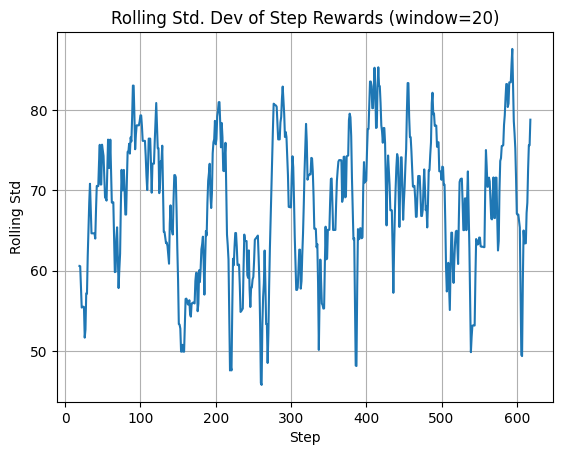

In [ ]:
rolling_std = pd.Series(rewards).rolling(window=20).std()
plt.plot(rolling_std)
plt.title("Rolling Std. Dev of Step Rewards (window=20)")
plt.xlabel("Step")
plt.ylabel("Rolling Std")
plt.grid(True)
plt.show()

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: SELL


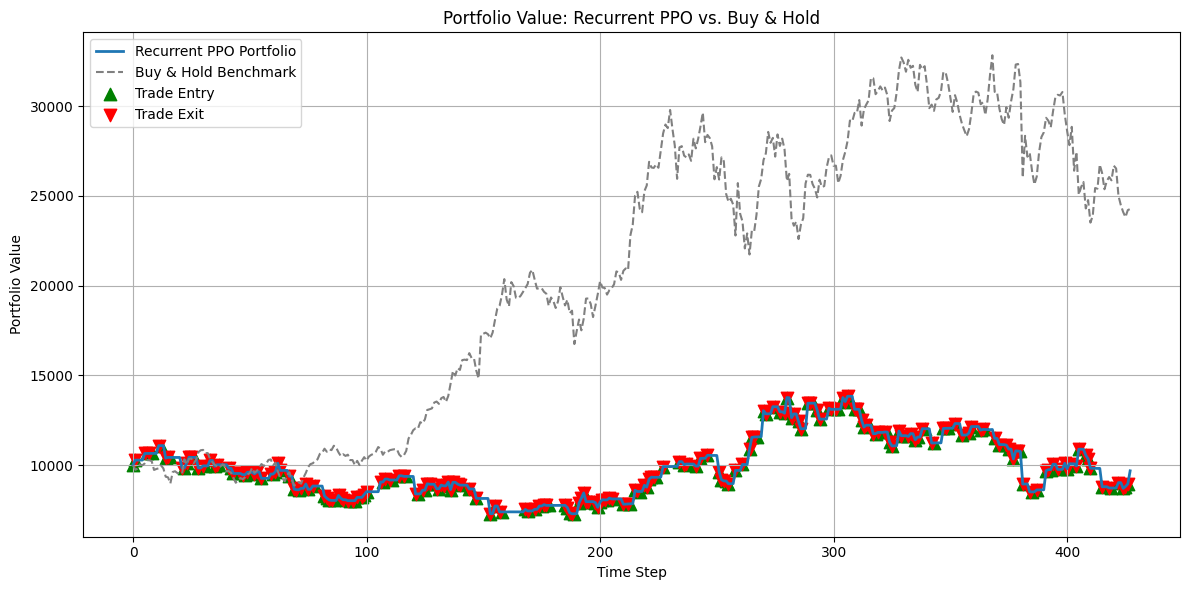

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## TSLA

In [ ]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [ ]:
# Parameters
ticker = "TSLA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [ ]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open     volume  \
0 2023-06-09  244.399994  252.419998  242.020004  249.070007  199882300   
1 2023-06-12  249.830002  250.970001  244.589996  247.940002  150337900   
2 2023-06-13  258.709991  259.679993  251.339996  253.509995  162384300   
3 2023-06-14  256.790009  261.570007  250.500000  260.170013  170575500   
4 2023-06-15  255.899994  258.950012  247.289993  248.399994  160171200   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  244.399994  244.399994  244.399994  244.399994  ...         1         0   
1  244.612935  244.507519  244.454024  244.421671  ...         0         0   
2  245.165761  244.788756  244.595874  244.478710  ...         0         0   
3  245.621614  245.026404  244.717209  244.527857  ...         0         0   
4  246.024688  245.241723  244.828480  244.573254  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0       

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 59945
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility  # 0.5x is the multiplier; tuneable
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 256 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0111028375 |
|    clip_fraction        | 0.0484       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.686       |
|    explained_variance   | -2.23e-05    |
|    learning_rate        | 0.01         |
|    loss                 | 2.04e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00278     |
|    value_loss           | 3.16e+05     |
------------------------------------------
-----

In [ ]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None  # <-- Track final model signal

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action  # <-- Capture the most recent model action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-02: BUY
Total Reward: -926.38
Final Balance: 11138.04
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-20  2023-07-21    Short      262.90     260.02   1.11   
1    2023-07-24  2023-07-27    Short      269.06     255.71   5.22   
2    2023-07-28  2023-07-31    Short      266.44     267.43  -0.37   
3    2023-08-01  2023-08-07    Short      261.07     251.45   3.83   
4    2023-08-08  2023-08-09     Long      249.70     242.19  -3.01   
..          ...         ...      ...         ...        ...    ...   
169  2025-03-19  2025-03-25    Short      235.86     288.14 -18.14   
170  2025-03-25  2025-03-26     Long      288.14     272.06  -5.58   
171  2025-03-26  2025-03-28    Short      272.06     263.55   3.23   
172  2025-03-28  2025-03-31     Long      263.55     259.16  -1.67   
173  2025-04-01  2025-04-03     Long      268.46     267.28  -0.44   

     CumulativePnL%  CompoundedFactor  Compoun

In [ ]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-03: BUY


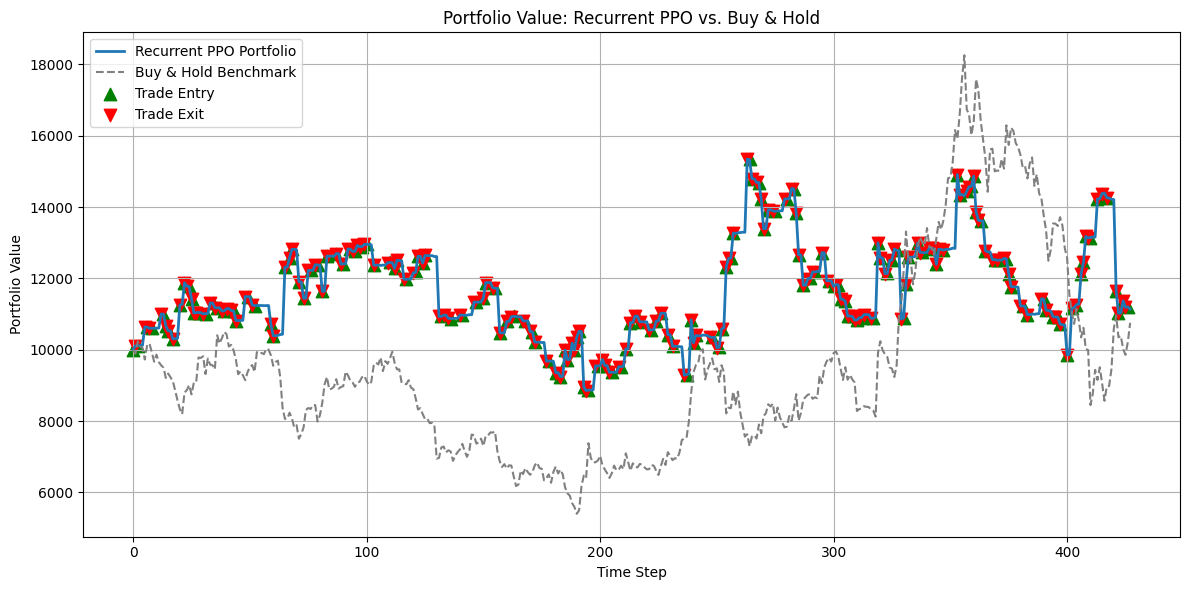

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

--- Training with seed 59945 ---
Seed 59945: Reward = 4603.65, Final Balance = 16611.51
Average reward for action Long: 0.2207
Average reward for action Short: -0.2924
Best model updated and saved.

--- Training with seed 35238 ---
Seed 35238: Reward = -5542.57, Final Balance = 6749.83
Average reward for action Long: 0.1086
Average reward for action Short: 0.0902

--- Training with seed 114865 ---
Seed 114865: Reward = -3284.99, Final Balance = 8733.03
Average reward for action Long: 0.4303
Average reward for action Short: -0.0503

--- Training with seed 78669 ---
Seed 78669: Reward = -2512.50, Final Balance = 9632.86
Average reward for action Long: 0.2388
Average reward for action Short: -0.0676

--- Training with seed 43151 ---
Seed 43151: Reward = -7168.18, Final Balance = 5077.19
Average reward for action Long: 0.6248
Average reward for action Short: -0.5181

--- Training with seed 43066 ---
Seed 43066: Reward = -3972.11, Final Balance = 8274.89
Average reward for action Long: 0.0365
Average reward for action Short: -0.3647

--- Training with seed 85160 ---
Seed 85160: Reward = 532.95, Final Balance = 12320.01
Average reward for action Long: 0.3442
Average reward for action Short: -0.7085

--- Training with seed 46098 ---
Seed 46098: Reward = -1975.02, Final Balance = 10030.74
Average reward for action Long: 0.4648
Average reward for action Short: -0.0405

--- Training with seed 114441 ---
Seed 114441: Reward = -8088.23, Final Balance = 4261.19
Average reward for action Long: -0.2435
Average reward for action Short: -0.5577

--- Training with seed 131940 ---
Seed 131940: Reward = -4858.41, Final Balance = 7310.32
Average reward for action Long: 0.3838
Average reward for action Short: -0.2375

--- Training with seed 40394 ---
Seed 40394: Reward = -934.32, Final Balance = 10846.89
Average reward for action Long: 0.1877
Average reward for action Short: -0.3429

--- Seed Sweep Complete ---
Best Seed: 59945
Best Total Reward: 4603.65
Best Final Balance: 16611.51

In [ ]:
model.save("TSLA_best_model")

## Changelog

### Version 2.5.0
- Updated model rules and tests

Version: 2.2.0
- Added per model saving
- Split entry points from Gradio
- Organization cleanup

### 2.1.0
- New major features: Recurrent PPO module training, seed search, and portfolio performance testing
- Removed DQN module
- Improved CSV saving function

### 1.2.3
- Adjusted default weights

### 1.2.2
- Fixed trade table
- Minor formatting

### 1.2.1
- Added trade table
- Added user adjustable weights
- Added basic MACD
- Added trade signals